# **OLA - Ensemble Learning**

**About OLA**

   Ola is India’s largest mobility platform and one of the world’s largest ride-hailing companies, serving 250+ cities across India, Australia, New Zealand, and the UK. It operates as an online cab aggregator that provides a mobile application for booking a cab connecting cab drivers and customers. The company also offers on-demand auto rickshaw service, car-sharing, and bicycle-sharing services.
    
**Problem Statement**

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

>* Demographics (city, age, gender etc.)
>* Tenure information (joining date, Last Date)
>* Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

**Column Profiling:**

>* **MMMM-YY :** Reporting Date (Monthly)
>* **Driver_ID :** Unique id for drivers
>* **Age :** Age of the driver
>* **Gender :** Gender of the driver – Male : 0, Female: 1
>* **City :** City Code of the driver
>* **Education_Level :** Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
>* **Income :** Monthly average Income of the driver
>* **Date Of Joining :** Joining date for the driver
>* **LastWorkingDate :** Last date of working for the driver
>* **Joining Designation :** Designation of the driver at the time of joining
>* **Grade :** Grade of the driver at the time of reporting
>* **Total Business Value :** The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
>* **Quarterly Rating :** Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

**Concepts Used:**

>* Ensemble Learning using Bagging technique - **Random Forest**
>* Ensemble Learning using Boosting technique - **Gradient Boosting DT and XGBooster**
>* KNN Imputation of Missing Values
>* Working with an imbalanced dataset

In [1]:
!gdown "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv"

Downloading...
From: https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv
To: C:\Users\Mrudula Madhavan\Desktop\Python Projects\Business Case\OLA - Ensemble Learning\ola_driver_scaler.csv

  0%|          | 0.00/1.13M [00:00<?, ?B/s]
 46%|####6     | 524k/1.13M [00:00<00:00, 4.16MB/s]
 93%|#########2| 1.05M/1.13M [00:00<00:00, 3.83MB/s]
100%|##########| 1.13M/1.13M [00:00<00:00, 3.91MB/s]


In [2]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [3]:
# Loading the dataset
df = pd.read_csv("ola_driver_scaler.csv")
df.head()

Unnamed: 0    MMM-YY  Driver_ID   Age  Gender City  Education_Level  \
0           0  01/01/19          1  28.0     0.0  C23                2   
1           1  02/01/19          1  28.0     0.0  C23                2   
2           2  03/01/19          1  28.0     0.0  C23                2   
3           3  11/01/20          2  31.0     0.0   C7                2   
4           4  12/01/20          2  31.0     0.0   C7                2   

   Income Dateofjoining LastWorkingDate  Joining Designation  Grade  \
0   57387      24/12/18             NaN                    1      1   
1   57387      24/12/18             NaN                    1      1   
2   57387      24/12/18        03/11/19                    1      1   
3   67016      11/06/20             NaN                    2      2   
4   67016      11/06/20             NaN                    2      2   

   Total Business Value  Quarterly Rating  
0               2381060                 2  
1               -665480                 2  
2                     0                 2  
3                     0                 1  
4                     0                 1

In [4]:
# Examine shape of dataset
df.shape

(19104, 14)

Our dataset have 19104 rows and 14 columns.

In [5]:
df.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [6]:
df.drop(['Unnamed: 0'], axis=1,inplace=True)

In [7]:
# check for the data types of values provided and see if any columns has the missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


**Observations**
* The Gender, Age has the highest number of missing data and datatypes of those missing features are non numeric data types.
* LastWorkingDate has highest number of missing data which needs to be aggragated since we have multiple columns for
same driver id.

In [8]:
##Converting 'MMM-YY' feature to datetime type
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])

##Converting 'Dateofjoining' feature to datetime type
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])

##Converting 'LastWorkingDate' feature to datetime type
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])


In [9]:
df.dtypes

MMM-YY                  datetime64[ns]
Driver_ID                        int64
Age                            float64
Gender                         float64
City                            object
Education_Level                  int64
Income                           int64
Dateofjoining           datetime64[ns]
LastWorkingDate         datetime64[ns]
Joining Designation              int64
Grade                            int64
Total Business Value             int64
Quarterly Rating                 int64
dtype: object

In [10]:
# Statistical summary for numerical variables.
df.describe().round(2).T

count       mean         std        min      25%  \
Driver_ID             19104.0    1415.59      810.71        1.0    710.0   
Age                   19043.0      34.67        6.26       21.0     30.0   
Gender                19052.0       0.42        0.49        0.0      0.0   
Education_Level       19104.0       1.02        0.80        0.0      0.0   
Income                19104.0   65652.03    30914.52    10747.0  42383.0   
Joining Designation   19104.0       1.69        0.84        1.0      1.0   
Grade                 19104.0       2.25        1.03        1.0      1.0   
Total Business Value  19104.0  571662.07  1128312.22 -6000000.0      0.0   
Quarterly Rating      19104.0       2.01        1.01        1.0      1.0   

                           50%       75%         max  
Driver_ID               1417.0    2137.0      2788.0  
Age                       34.0      39.0        58.0  
Gender                     0.0       1.0         1.0  
Education_Level            1.0       2.0         2.0  
Income                 60087.0   83969.0    188418.0  
Joining Designation        1.0       2.0         5.0  
Grade                      2.0       3.0         5.0  
Total Business Value  250000.0  699700.0  33747720.0  
Quarterly Rating           2.0       3.0         4.0

* Mean and Median for Income and Total Business Value significantly differ and indicative of outliers.

In [11]:
# Descriptive analysis of categorical columns
df.describe(include = ["object"]).T

count unique  top  freq
City  19104     29  C20  1008

In [12]:
# Display the no. of unique values in each column
df.nunique()

MMM-YY                     24
Driver_ID                2381
Age                        36
Gender                      2
City                       29
Education_Level             3
Income                   2383
Dateofjoining             869
LastWorkingDate           493
Joining Designation         5
Grade                       5
Total Business Value    10181
Quarterly Rating            4
dtype: int64

In [13]:
# Check for the duplicate values in dataset
df.duplicated().sum()

0

There are no duplicate records in our dataset.

In [14]:
# Check for the missing values in dataset
null_total = df.isna().sum().sort_values(ascending = False)
null_percent =((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending = False)
null = pd.concat([null_total,null_percent.round(4)],axis=1,keys=['Missing Total','Missing Percent'])
null

Missing Total  Missing Percent
LastWorkingDate               17488          91.5410
Age                              61           0.3193
Gender                           52           0.2722
MMM-YY                            0           0.0000
Driver_ID                         0           0.0000
City                              0           0.0000
Education_Level                   0           0.0000
Income                            0           0.0000
Dateofjoining                     0           0.0000
Joining Designation               0           0.0000
Grade                             0           0.0000
Total Business Value              0           0.0000
Quarterly Rating                  0           0.0000

**Observations**
* We observed above that for drivers in active status their LastWorkingDate has highest number of missing data which needs to be aggragated since we have multiple columns for same driver id.Once we perform aggregation, we can address this discrepancy.
* The Gender, Age also have large number of missing values.

### **Missing Value Imputation using KNN**

In [15]:
# Extracting numerical columns and check for missing values
df_nums=df.select_dtypes(np.number)
df_nums.isnull().sum()

Driver_ID                0
Age                     61
Gender                  52
Education_Level          0
Income                   0
Joining Designation      0
Grade                    0
Total Business Value     0
Quarterly Rating         0
dtype: int64

We have missing values in Age and Gender columns.


In [16]:
df_nums.drop(columns='Driver_ID',inplace=True)
columns=df_nums.columns

In [17]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean',)
imputer.fit(df_nums)
# transform the dataset
df_new = imputer.transform(df_nums)
df_new=pd.DataFrame(df_new)
df_new.columns=columns

In [18]:
df_new.isnull().sum()

Age                     0
Gender                  0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
dtype: int64

In [19]:
remaining_columns=list(set(df.columns).difference(set(columns)))
df =pd.concat([df_new, df[remaining_columns]],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Age                   19104 non-null  float64       
 1   Gender                19104 non-null  float64       
 2   Education_Level       19104 non-null  float64       
 3   Income                19104 non-null  float64       
 4   Joining Designation   19104 non-null  float64       
 5   Grade                 19104 non-null  float64       
 6   Total Business Value  19104 non-null  float64       
 7   Quarterly Rating      19104 non-null  float64       
 8   MMM-YY                19104 non-null  datetime64[ns]
 9   City                  19104 non-null  object        
 10  Dateofjoining         19104 non-null  datetime64[ns]
 11  LastWorkingDate       1616 non-null   datetime64[ns]
 12  Driver_ID             19104 non-null  int64         
dtypes: datetime64[ns

In [20]:
for col in df.select_dtypes(np.number):
    df[col] = df[col].astype('int64')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Age                   19104 non-null  int64         
 1   Gender                19104 non-null  int64         
 2   Education_Level       19104 non-null  int64         
 3   Income                19104 non-null  int64         
 4   Joining Designation   19104 non-null  int64         
 5   Grade                 19104 non-null  int64         
 6   Total Business Value  19104 non-null  int64         
 7   Quarterly Rating      19104 non-null  int64         
 8   MMM-YY                19104 non-null  datetime64[ns]
 9   City                  19104 non-null  object        
 10  Dateofjoining         19104 non-null  datetime64[ns]
 11  LastWorkingDate       1616 non-null   datetime64[ns]
 12  Driver_ID             19104 non-null  int64         
dtypes: datetime64[ns

### **Feature Engineering**




In [22]:
# Creating new feature Quarter from MMM-YY column
df['MMM-YY']=pd.to_datetime(df['MMM-YY'])
df.loc[df['MMM-YY'].dt.month <=3, 'Quarter'] = 'Q1'
df.loc[(df['MMM-YY'].dt.month >3) & (df['MMM-YY'].dt.month <=6) , 'Quarter'] = 'Q2'
df.loc[(df['MMM-YY'].dt.month >6) & (df['MMM-YY'].dt.month <=9) , 'Quarter'] = 'Q3'
df.loc[(df['MMM-YY'].dt.month >9) & (df['MMM-YY'].dt.month <=12) , 'Quarter'] = 'Q4'

1) QuatertlyRatingStatus

* Create a column **QuatertlyRatingStatus** which tells whether the quarterly rating has increased for that driver - for those whose quarterly rating has increased we assign the value 1.

2) IncomeLevelStatus
* Create a column **IncomeLevelStatus** which tells whether the monthly income has increased for that driver - for those whose monthly income has increased we assign the value 1

In [23]:
#  QuatertlyRatingStatus
grouped_data = df.groupby('Driver_ID')['Quarterly Rating'].agg(['first','last'])
grouped_data['QuaterlyRatingstatus']=grouped_data['last']-grouped_data['first']


In [24]:
# IncomeLevelStatus
df['IncomeLevelStatus'] = df.groupby('Driver_ID')['Income'].diff()

In [25]:
create_aggregation_dict = { 'Age':'last',
                            'Gender':'last',
                            'City':'last',
                            'Education_Level':'last',
                            'Income': 'last',
                            'Quarter':'last',
                            'LastWorkingDate':'last',
                            'Joining Designation':'first',
                            'Grade':'first',
                            'Total Business Value':'sum',
                            'Quarterly Rating': 'last',
                            'IncomeLevelStatus':'last','MMM-YY':'last','Dateofjoining':'last'
                            }
data = df.groupby('Driver_ID').agg(create_aggregation_dict).reset_index()
data['QuaterlyRatingStatus'] = grouped_data.reset_index()['QuaterlyRatingstatus']

In [26]:
df['IncomeLevelStatus'] = df['IncomeLevelStatus'].fillna(0)

In [27]:
#  QuatertlyRatingStatus 0 -> decline/No change 1 -> Increase
#  IncomeLevelStatus 0 -> decline/No change 1 -> Increase
for col in ['QuaterlyRatingStatus','IncomeLevelStatus']:
 conditions = [ data[col] <= 0.0, data[col] > 0.0 ]
 choices = [0, 1]
 data[col] = np.select(conditions, choices)


In [28]:
data['QuaterlyRatingStatus'].value_counts()

0    2023
1     358
Name: QuaterlyRatingStatus, dtype: int64

In [29]:
data['IncomeLevelStatus'].value_counts()

0    2370
1      11
Name: IncomeLevelStatus, dtype: int64

3) **Target column - IsDriverChurned**
* Create a column called **IsDriverChurned** which tells whether the driver has left the company - driver whose last working day is present will have the value 1

In [30]:
data['IsDriverChurned'] = np.where(data['LastWorkingDate'].isnull(), 'No', 'Yes')

Our target variable **'IsDriverChurned'** on the basis of lastworking date.
* 1 - Driver left
* 0 - Still working

In [31]:
data.IsDriverChurned.value_counts()

Yes    1616
No      765
Name: IsDriverChurned, dtype: int64

In [32]:
def gender(val):
    if val == 0.0:
        return 0
    elif val >= 0.0:
        return 1
    else:
        return val
data["Gender"] = data["Gender"].apply(gender)

In [33]:
# Changing datatype of columns
cols = ['Gender', 'Education_Level', 'Joining Designation','Grade','Quarterly Rating',
        'QuaterlyRatingStatus','IncomeLevelStatus','IsDriverChurned','City']
for col in cols:
 data[col] = data[col].astype('category')

5) Reporting Month and Year

In [34]:
data['Reporting_Year'] = data['MMM-YY'].dt.year
data['Reporting_Month'] = data['MMM-YY'].dt.month

6) Joining Day, Month and Year

In [35]:
 # Getting feature engineering month, day and year for date_time columns dateofjoining and last working date
data['DOJ_month'] = data['Dateofjoining'].dt.month
data['DOJ_year'] = data['Dateofjoining'].dt.year
data['DOJ_day'] = data['Dateofjoining'].dt.day

7) Total years of experience

In [36]:
data['Year_exp_No_LWD'] = data[data['LastWorkingDate'].isna()]['Reporting_Year'] - data[data['LastWorkingDate'].isna()]['DOJ_year']
# df['Year_exp_No_LWD'].value_counts(dropna=False)
data['Year_exp_LWD'] = pd.to_datetime(data[~ data['LastWorkingDate'].isna()]['LastWorkingDate']).dt.year - data[~ data['LastWorkingDate'].isna()]['DOJ_year']
# df['Year_exp_LWD'].value_counts(dropna=False)
data['Year_exp_No_LWD'].fillna(0,inplace=True)
data['Year_exp_LWD'].fillna(0,inplace=True)
data["Total_Yrs_Exp"] = data['Year_exp_No_LWD'] + data['Year_exp_LWD']
data.drop(['Year_exp_LWD','Year_exp_No_LWD','LastWorkingDate','Dateofjoining'],axis=1,inplace = True)

In [37]:
data.columns

Index(['Driver_ID', 'Age', 'Gender', 'City', 'Education_Level', 'Income',
       'Quarter', 'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating', 'IncomeLevelStatus', 'MMM-YY',
       'QuaterlyRatingStatus', 'IsDriverChurned', 'Reporting_Year',
       'Reporting_Month', 'DOJ_month', 'DOJ_year', 'DOJ_day', 'Total_Yrs_Exp'],
      dtype='object')

### **Derived dataset**

In [38]:
data = data[['Driver_ID', 'Age', 'Gender', 'City', 'Education_Level','Joining Designation', 'Grade', 'Total Business Value',
            'Income','IncomeLevelStatus','Quarterly Rating','QuaterlyRatingStatus','Reporting_Year','Quarter','Reporting_Month',
             'DOJ_month', 'DOJ_year', 'DOJ_day','Total_Yrs_Exp','IsDriverChurned']]

In [39]:
data.head()

Driver_ID  Age Gender City Education_Level Joining Designation Grade  \
0          1   28      0  C23               2                   1     1   
1          2   31      0   C7               2                   2     2   
2          4   43      0  C13               2                   2     2   
3          5   29      0   C9               0                   1     1   
4          6   31      1  C11               1                   3     3   

   Total Business Value  Income IncomeLevelStatus Quarterly Rating  \
0               1715580   57387                 0                2   
1                     0   67016                 0                1   
2                350000   65603                 0                1   
3                120360   46368                 0                1   
4               1265000   78728                 0                2   

  QuaterlyRatingStatus  Reporting_Year Quarter  Reporting_Month  DOJ_month  \
0                    0            2019      Q1                3         12   
1                    0            2020      Q4               12         11   
2                    0            2020      Q2                4         12   
3                    0            2019      Q1                3          1   
4                    1            2020      Q4               12          7   

   DOJ_year  DOJ_day  Total_Yrs_Exp IsDriverChurned  
0      2018       24            1.0             Yes  
1      2020        6            0.0              No  
2      2019        7            1.0             Yes  
3      2019        9            0.0             Yes  
4      2020       31            0.0              No

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Driver_ID             2381 non-null   int64   
 1   Age                   2381 non-null   int64   
 2   Gender                2381 non-null   category
 3   City                  2381 non-null   category
 4   Education_Level       2381 non-null   category
 5   Joining Designation   2381 non-null   category
 6   Grade                 2381 non-null   category
 7   Total Business Value  2381 non-null   int64   
 8   Income                2381 non-null   int64   
 9   IncomeLevelStatus     2381 non-null   category
 10  Quarterly Rating      2381 non-null   category
 11  QuaterlyRatingStatus  2381 non-null   category
 12  Reporting_Year        2381 non-null   int64   
 13  Quarter               2381 non-null   object  
 14  Reporting_Month       2381 non-null   int64   
 15  DOJ_

In [41]:
# Check for the missing values in aggregated dataset
data.isna().sum()/len(data)*100

Driver_ID               0.0
Age                     0.0
Gender                  0.0
City                    0.0
Education_Level         0.0
Joining Designation     0.0
Grade                   0.0
Total Business Value    0.0
Income                  0.0
IncomeLevelStatus       0.0
Quarterly Rating        0.0
QuaterlyRatingStatus    0.0
Reporting_Year          0.0
Quarter                 0.0
Reporting_Month         0.0
DOJ_month               0.0
DOJ_year                0.0
DOJ_day                 0.0
Total_Yrs_Exp           0.0
IsDriverChurned         0.0
dtype: float64

In [42]:
# Statistical summary for numerical variables.
data.describe().round(2).T

count        mean         std        min      25%  \
Driver_ID             2381.0     1397.56      806.16        1.0    695.0   
Age                   2381.0       33.67        5.97       21.0     29.0   
Total Business Value  2381.0  4586741.82  9127115.31 -1385530.0      0.0   
Income                2381.0    59334.16    28383.67    10747.0  39104.0   
Reporting_Year        2381.0     2019.65        0.48     2019.0   2019.0   
Reporting_Month       2381.0        8.17        3.89        1.0      5.0   
DOJ_month             2381.0        7.36        3.14        1.0      5.0   
DOJ_year              2381.0     2018.54        1.61     2013.0   2018.0   
DOJ_day               2381.0       15.79        9.37        1.0      7.0   
Total_Yrs_Exp         2381.0        1.11        1.53        0.0      0.0   

                           50%        75%         max  
Driver_ID               1400.0     2100.0      2788.0  
Age                       33.0       37.0        58.0  
Total Business Value  817680.0  4173650.0  95331060.0  
Income                 55315.0    75986.0    188418.0  
Reporting_Year          2020.0     2020.0      2020.0  
Reporting_Month            9.0       12.0        12.0  
DOJ_month                  7.0       10.0        12.0  
DOJ_year                2019.0     2020.0      2020.0  
DOJ_day                   15.0       24.0        31.0  
Total_Yrs_Exp              1.0        1.0         7.0

### **Observation**
* Mean Driver age is around 33.6 years, Median Driver age is 33 years whereas maximum driver age is 49 while the youngest driver onboarded is of 21 yrs.
* There are 29 citites for which data currently is available with Ola. Most drivers hail from C20.
* Avg. Income of Drivers is 59k, while median salary lies around 55k and minimum salary is around 10k.
* Avg. Quarterly Rating is 1.56 while median quarterly rating is around 1.
* Avg. Total Experience with OLA is 0.97 years while median age is 1 with maximum total year of experience is 7 years.

In [43]:
# Descriptive analysis of categorical columns
data.describe(include = ['object','category']).T

count unique  top  freq
Gender                2381      2    0  1406
City                  2381     29  C20   152
Education_Level       2381      3    2   802
Joining Designation   2381      5    1  1026
Grade                 2381      5    2   866
IncomeLevelStatus     2381      2    0  2370
Quarterly Rating      2381      4    1  1744
QuaterlyRatingStatus  2381      2    0  2023
Quarter               2381      4   Q4  1142
IsDriverChurned       2381      2  Yes  1616

In [44]:
# Display the no. of unique values in each column
data.nunique()

Driver_ID               2381
Age                       36
Gender                     2
City                      29
Education_Level            3
Joining Designation        5
Grade                      5
Total Business Value    1629
Income                  2339
IncomeLevelStatus          2
Quarterly Rating           4
QuaterlyRatingStatus       2
Reporting_Year             2
Quarter                    4
Reporting_Month           12
DOJ_month                 12
DOJ_year                   8
DOJ_day                   31
Total_Yrs_Exp              8
IsDriverChurned            2
dtype: int64

In [45]:
data.drop(columns=['Driver_ID'], inplace=True)

# **Exploratory Data Analysis**
### **Univariate Analysis**

In [46]:
data_num = ['Age', 'Total Business Value', 'Income']
data_cat = ['Gender', 'City', 'Education_Level', 'Joining Designation','Grade', 'Quarterly Rating',
                      'IncomeLevelStatus','QuaterlyRatingStatus','Reporting_Year','Reporting_Month','Quarter',
                      'DOJ_month', 'DOJ_year', 'DOJ_day','Total_Yrs_Exp','IsDriverChurned']
for col in data_cat:
    data[col] = data[col].astype('category')

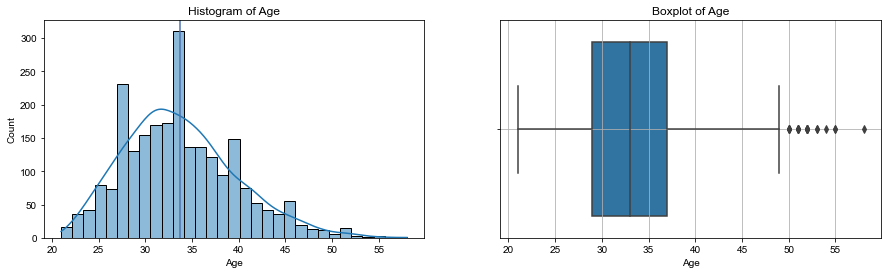

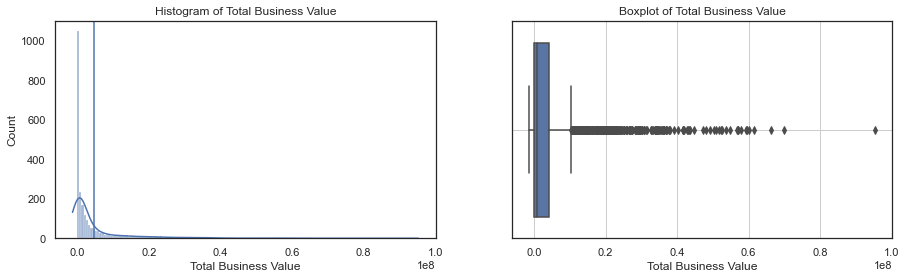

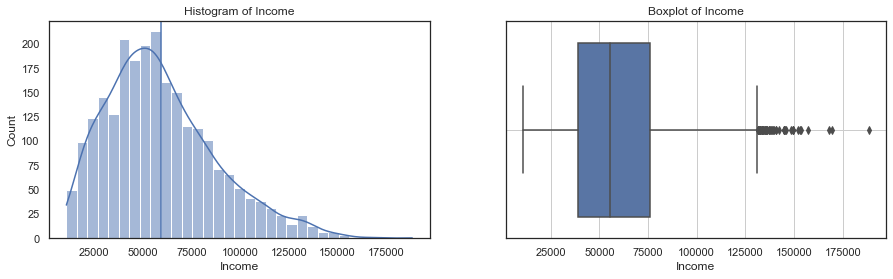

In [47]:
# Univariate analysis for numerical columns
def univariate(x,y):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    sns.histplot(x,kde=True,ax=ax)
    ax.axvline(x.mean())
    ax2 = fig.add_subplot(122)
    sns.boxplot(x = x,data=df,ax=ax2)
    ax.set_title("Histogram of " + y)
    ax2.set_title("Boxplot of "+y)
    sns.set(style='white')
    plt.grid()
    plt.show()


for i in ['Age', 'Total Business Value', 'Income']:
    univariate(data[i],str(i))

* Histogram of Total Business value tells us so abnormality among the drivers making business.Most of drivers making business value lies in low region.
* The distribution of total business value is towards the right. There are a lot of outliers for the feature Total Business Value.
* The distribution of income is towards the right and there are outliers for this feature as well.
*  Age data is  normaly distributed. Median is at 34 years .Very less outliers present but it's age of driver so we will consider it as value information.


In [48]:
for col in  ['Gender','Education_Level','Joining Designation','Grade','Quarterly Rating','City',
             'IncomeLevelStatus','QuaterlyRatingStatus']:
    print(data[col].value_counts(normalize=True).round(4)*100)
    print("--"*40)

0    59.05
1    40.95
Name: Gender, dtype: float64
--------------------------------------------------------------------------------
2    33.68
1    33.39
0    32.93
Name: Education_Level, dtype: float64
--------------------------------------------------------------------------------
1    43.09
2    34.23
3    20.71
4     1.51
5     0.46
Name: Joining Designation, dtype: float64
--------------------------------------------------------------------------------
2    36.37
1    31.54
3    25.66
4     5.54
5     0.88
Name: Grade, dtype: float64
--------------------------------------------------------------------------------
1    73.25
2    15.20
3     7.06
4     4.49
Name: Quarterly Rating, dtype: float64
--------------------------------------------------------------------------------
C20    6.38
C15    4.24
C29    4.03
C26    3.91
C8     3.74
C27    3.74
C10    3.61
C16    3.53
C22    3.44
C3     3.44
C28    3.44
C12    3.40
C5     3.36
C1     3.36
C21    3.32
C14    3.32
C6     3.28
C4    

### **Observations**
- **Around 59% employees are of the Male gender.**
- **Around 6.4% employees are from city C20 and 4.2% from city C15.**
- **The proportion of the employees who have completed their Graduate and 12th is approximately same.**
- **Around 43% of the employees joined with the grade 1.**
- **At the time of reporting, 34% of the employees had their grade as 2.**
- **Around 73% of the employees had their last quarterly rating as 1.**
- **The quarterly rating has not increased for around 87% employees.**

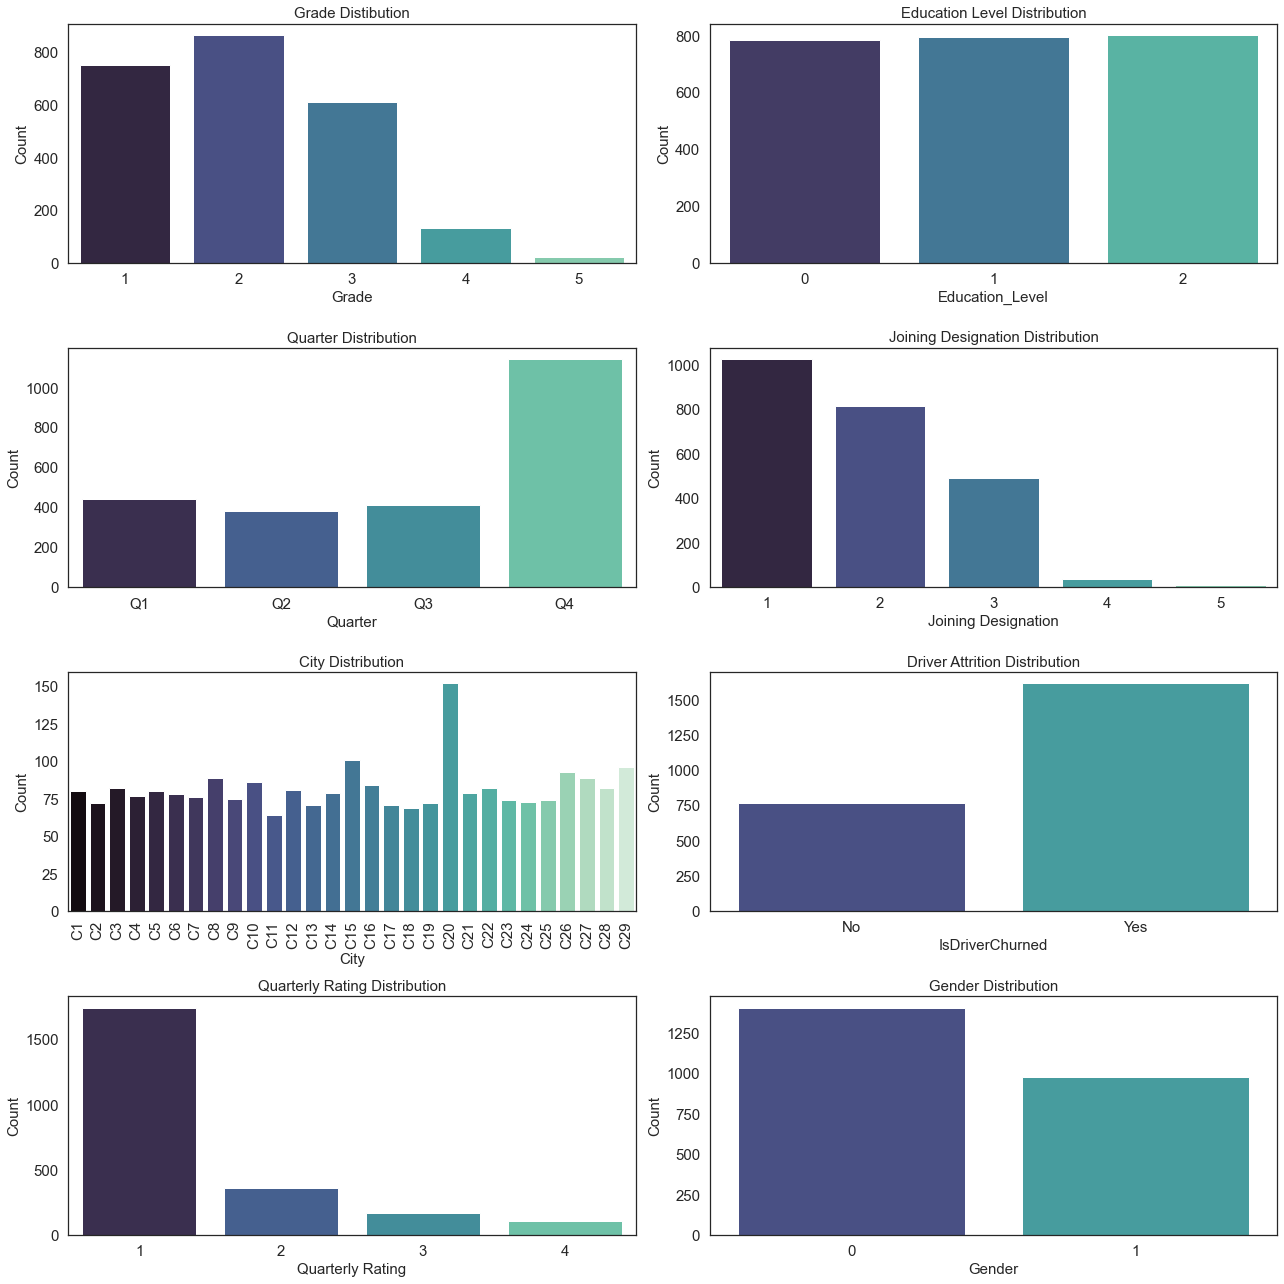

In [49]:
# Univariate analysis for categorical columns
fig, axs = plt.subplots(4, 2, figsize=(18,18), sharey=False)

Grade = [1,2,3,4,5]
graph = sns.countplot(x = 'Grade', data= data, ax = axs[0][0],palette='mako', order = Grade)
graph.set_title("Grade Distibution", fontsize = 15)
graph.set_xlabel('Grade', fontsize=15);
graph.set_ylabel('Count', fontsize=15);
graph.tick_params(axis='both', which='major', labelsize=15)


Education_Level = sorted(data.Education_Level.unique().tolist())
graph = sns.countplot(x = 'Education_Level', data = data, ax = axs[0][1], palette='mako', order = Education_Level)
graph.set_title("Education Level Distribution", fontsize = 15)
graph.set_xticklabels(graph.get_xticklabels())
graph.set_xlabel('Education_Level', fontsize=15);
graph.set_ylabel('Count', fontsize=15);
graph.tick_params(axis='both', which='major', labelsize=15)

graph = sns.countplot(x = 'Quarter', data= data, ax = axs[1][0],palette='mako')
graph.set_title("Quarter Distribution", fontsize = 15)
graph.set_xlabel('Quarter', fontsize=15);
graph.set_ylabel('Count', fontsize=15);
graph.tick_params(axis='both', which='major', labelsize=15)

JoiningDesignation = sorted(data['Joining Designation'].unique().tolist())
graph = sns.countplot(x = 'Joining Designation', data = data, ax = axs[1][1], palette='mako', order = JoiningDesignation)
graph.set_title("Joining Designation Distribution", fontsize = 15)
graph.set_xticklabels(graph.get_xticklabels())
graph.set_xlabel('Joining Designation', fontsize=15);
graph.set_ylabel('Count', fontsize=15);
graph.tick_params(axis='both', which='major', labelsize=15)

graph = sns.countplot(x = 'Gender', data= data, ax = axs[3][1],palette='mako')
graph.set_title("Gender Distribution", fontsize = 15)
graph.set_xlabel('Gender', fontsize=15);
graph.set_ylabel('Count', fontsize=15);
graph.tick_params(axis='both', which='major', labelsize=15)

City = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10',
        'C11','C12','C13','C14','C15','C16','C17','C18','C19','C20',
        'C21','C22','C23','C24','C25','C26','C27','C28','C29']
graph = sns.countplot(x = 'City', data = data, ax = axs[2][0], palette='mako', order = City)
graph.set_title("City Distribution", fontsize = 15)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.set_xlabel('City', fontsize=15);
graph.set_ylabel('Count', fontsize=15);
graph.tick_params(axis='both', which='major', labelsize=15)

QuarterlyRating = [1,2,3,4]
graph = sns.countplot(x = 'Quarterly Rating', data= data, ax = axs[3][0],palette='mako', order = QuarterlyRating)
graph.set_title("Quarterly Rating Distribution", fontsize = 15)
graph.set_xlabel('Quarterly Rating', fontsize=15);
graph.set_ylabel('Count', fontsize=15);
graph.tick_params(axis='both', which='major', labelsize=15)

graph = sns.countplot(x = 'IsDriverChurned', data= data, ax = axs[2][1],palette='mako')
graph.set_title("Driver Attrition Distribution", fontsize = 15)
graph.set_xlabel('IsDriverChurned', fontsize=15);
graph.set_ylabel('Count', fontsize=15);
graph.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

**Observations :**
* People with Grade 1 and 2 are higher in percentage wherever people with Grade 4 and 5 are lower.
* People with designation 1 and 2 are higher in percentage wherever people with designation 4 and 5 are lower.
* City code with C20 has highest no.of employees followed by C29 and C26.
* 41% are women and 59% are men drivers.
* 70% of drivers have a rating of 1 and only 4% have rating of 4.
* Only 3% have a joining designation of 4 or 5. 43% have a designation of 1.
* 36% of drivers fall into grade 2 and less than 2% fall into a higher grade. Indicating most of the driver population is relatively recently recruited. A strong indicator of the problem of attrition.
* More or less equal distribution of drivers at each of the three Education levels= 10+,12+ and graduate.

**Age**

In [50]:
data["Age"].value_counts(bins=10)  # Maximum driver average age is between 28 to 32 years.
                                 # very less driver age is above 50 years

(28.4, 32.1]      627
(32.1, 35.8]      448
(35.8, 39.5]      438
(24.7, 28.4]      384
(39.5, 43.2]      232
(20.962, 24.7]     94
(43.2, 46.9]       90
(46.9, 50.6]       48
(50.6, 54.3]       17
(54.3, 58.0]        3
Name: Age, dtype: int64

* Maximum driver average age is between 28 to 32 years and  very less driver age is above 50 years

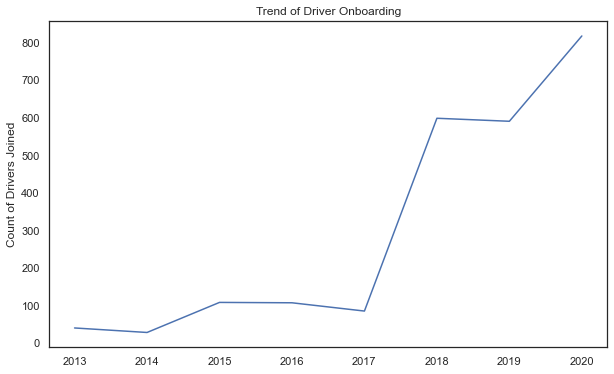

In [51]:
plt.figure(figsize=(10,6))
plt.title("Trend of Driver Onboarding")
sns.lineplot(x= data['DOJ_year'].value_counts().index,y=data['DOJ_year'].value_counts())
plt.ylabel("Count of Drivers Joined")
plt.show()

- We can around 1500k reporting in the organization in the year of 2019.
- We can see year on year increment in driver onboarding from the year of 2017 to 2018, where we see a plateau in the onboarding. From the year 2019 to 2020, we see a uptick in driver recruitment

**Target Variable - IsDriverChurned**

In [52]:
print(data["IsDriverChurned"].value_counts(normalize = True).round(3)*100)

Yes    67.9
No     32.1
Name: IsDriverChurned, dtype: float64


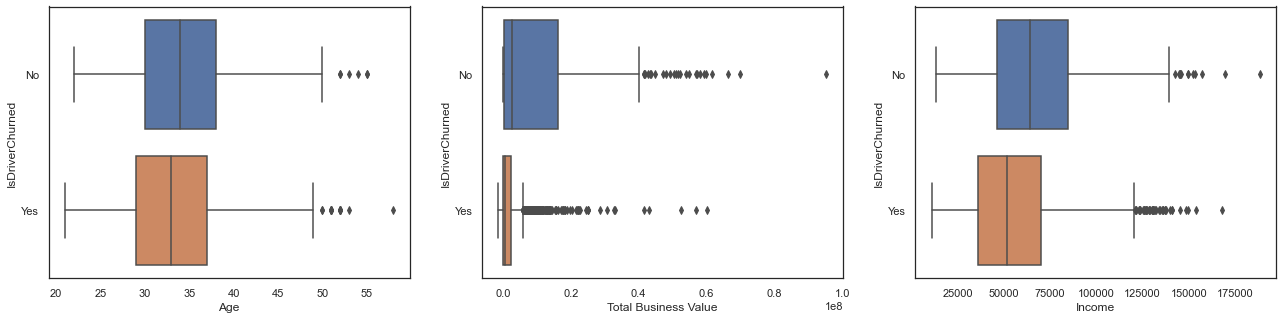

In [53]:
plt.figure(figsize=(22,5))
i = 1
for features in data_num:
    plt.subplot(1,3,i)
    sns.boxplot(x = data[features], y = data['IsDriverChurned'])
    i+=1

In [54]:
plt.figure(figsize=(12,5))
print(data["IsDriverChurned"].value_counts(normalize = True).round(3)*100)
fig = px.pie(data, names='IsDriverChurned', title="Percentage of Driver Attrition",template='gridon')
fig.update_traces(textposition='outside', textinfo='percent + label')

Yes    67.9
No     32.1
Name: IsDriverChurned, dtype: float64


<Figure size 864x360 with 0 Axes>

The distribution of target variable is non-uniform in the dataset given ie, **The data is imbalanced**

### **Observations**

- Male form 59%, Female drivers form 41% of Ola's fleet
- Education Level is generally equally distributed between 0,1 & 2 education level
- 43% Joining Designation the highest is represented by 1, while Joining Designation is 2 which constitutes 34%
- Driver Grades of 2 form 36%
- 68% form drivers who have left the organization while 32% form drivers who are still with the organization
- 85% drivers have not seen improvement in the quarterly rating.
- 98% drivers have not observed income increment.
- Most prominent age of drivers joining the organization forms 0 yrs. Closely followed by 1 yr.
- We can also observe a trend of decline wherein lots of drivers are not around post 1 year.

## **Bivariate Analysis based on Target variable**

In [55]:
# Age_bins
agebin=[20,25,30,35,40,45,50,55,60]
data['Age_bins'] = pd.cut(x=data['Age'], bins=agebin)

In [56]:
# Income_slabs
bins = [0,30000,40000,50000,60000,70000,80000, 200000]
labels = ['0-30k','30k-40k','40k-50k','50k-60k','60k-70k','70k-80k','80k-max']
data['Income_slabs'] = pd.cut(data['Income'], bins=bins,labels=labels)


In [57]:
# Crosstab Analysis
for col in ['Age_bins', 'Gender', 'City', 'Education_Level', 'Income_slabs','Quarter', 'Joining Designation', 'Grade',
       'Quarterly Rating', 'IncomeLevelStatus', 'QuaterlyRatingStatus']:
    print(pd.crosstab(data[col],data['IsDriverChurned'], margins = True))
    print("--"*40)


IsDriverChurned   No   Yes   All
Age_bins                        
(20, 25]          36   137   173
(25, 30]         184   406   590
(30, 35]         240   550   790
(35, 40]         194   307   501
(40, 45]          74   157   231
(45, 50]          31    45    76
(50, 55]           6    13    19
(55, 60]           0     1     1
All              765  1616  2381
--------------------------------------------------------------------------------
IsDriverChurned   No   Yes   All
Gender                          
0                458   948  1406
1                307   668   975
All              765  1616  2381
--------------------------------------------------------------------------------
IsDriverChurned   No   Yes   All
City                            
C1                24    56    80
C10               25    61    86
C11               19    45    64
C12               28    53    81
C13               13    58    71
C14               21    58    79
C15               32    69   101
C16          

### **Observations**
- **The proportion of gender and education is more or less the same for both the employees who left the organization and those who did not leave.**
- **The employees who have their grade as 3 or 4 at the time of joining are less likely to leave the organization.**
- **The employees who have their grade as 3 or 4 at the time of reporting are less likely to leave the organization.**
- **The employees who have their last quarterly rating as 3 or 4 at the time of reporting are less likely to leave the organization.**
- **The employees whose quarterly rating has increased are less likely to leave the organization.**

In [58]:
def CountPlot(x, figsize=(6,6)):
 plt.figure(figsize=figsize)
 sns.countplot(x = data[x], hue = data['IsDriverChurned']).set(title ='Driver attrition based on '+ x)
 plt.show()

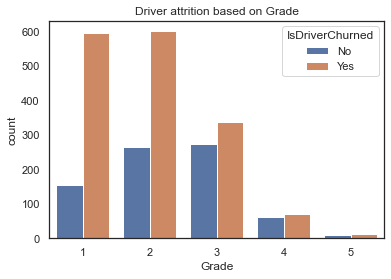

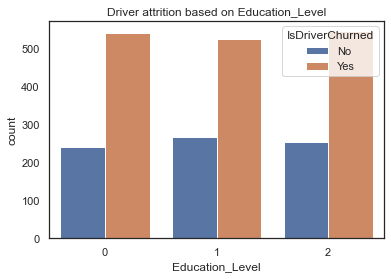

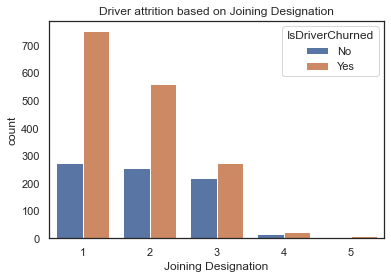

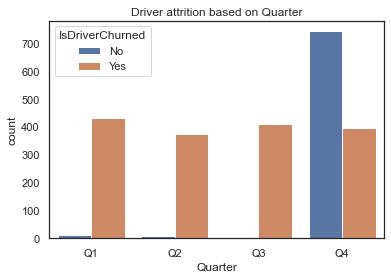

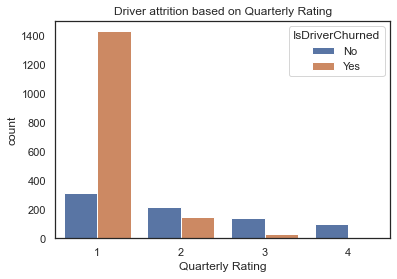

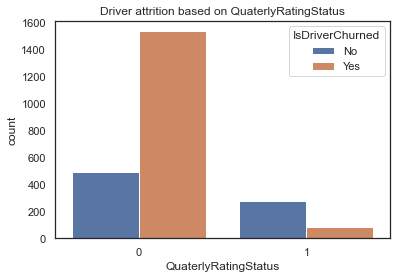

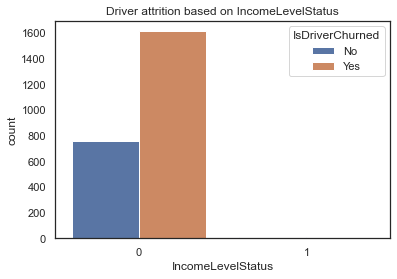

In [59]:
for col in ['Grade','Education_Level','Joining Designation','Quarter','Quarterly Rating','QuaterlyRatingStatus', 'IncomeLevelStatus']:
    CountPlot(col, figsize = (6,4))

**Observations :**
* Drivers who has Grade 1 and 2 having highest percentage difference in leaving the company.
* Joining Designation of drivers 1 and 2 showing more interest in leaving the company.
* Only Quartertly rating 1 drivers showing more interest in leaving the company.
* In 4th quarter of the year, Number of drivers leaving the company is less compared to drivers who retained in the company



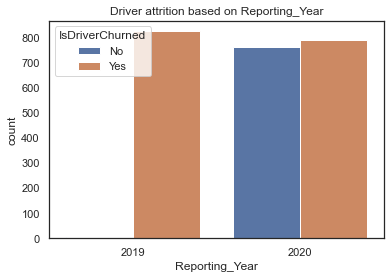

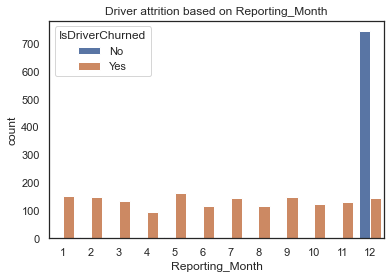

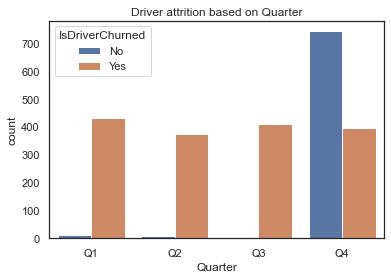

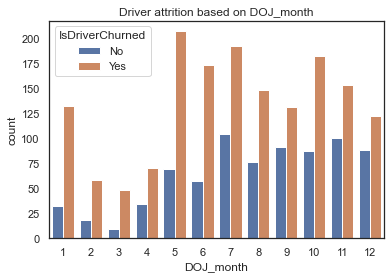

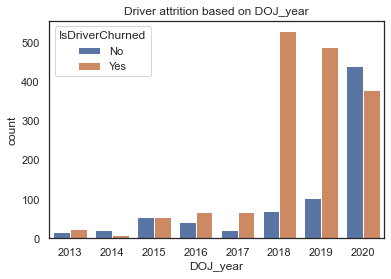

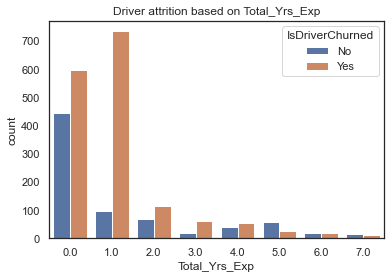

In [60]:
for col in ['Reporting_Year','Reporting_Month','Quarter','DOJ_month', 'DOJ_year','Total_Yrs_Exp']:
    CountPlot(col, figsize = (6,4))

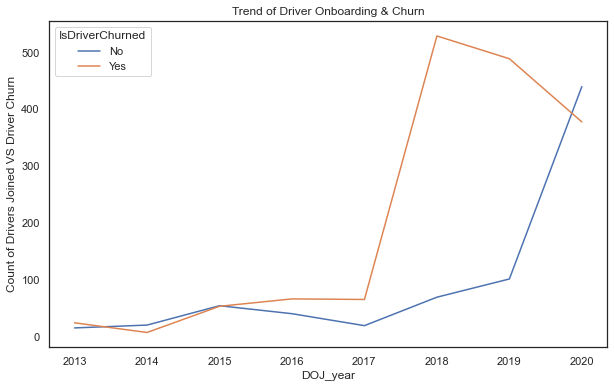

In [61]:
join_df = data[["DOJ_year",'IsDriverChurned']].value_counts().reset_index()
join_df.columns = ["DOJ_year","IsDriverChurned","Count"]
join_df.sort_values(by="DOJ_year",inplace=True)
plt.figure(figsize=(10,6))
plt.title("Trend of Driver Onboarding & Churn")
sns.lineplot(x=join_df['DOJ_year'],y=join_df['Count'],hue=join_df['IsDriverChurned'])
plt.ylabel("Count of Drivers Joined VS Driver Churn")
plt.show()


[Text(0.5, 1.0, 'Number of drivers retained based on Age group')]

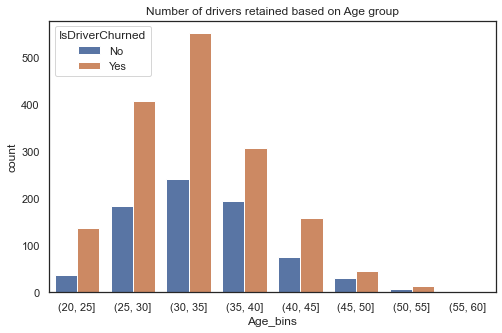

In [62]:
plt.figure(figsize=(8,5))
sns.countplot(x = data['Age_bins'], hue = data['IsDriverChurned']).set(title ='Number of drivers retained based on Age group')

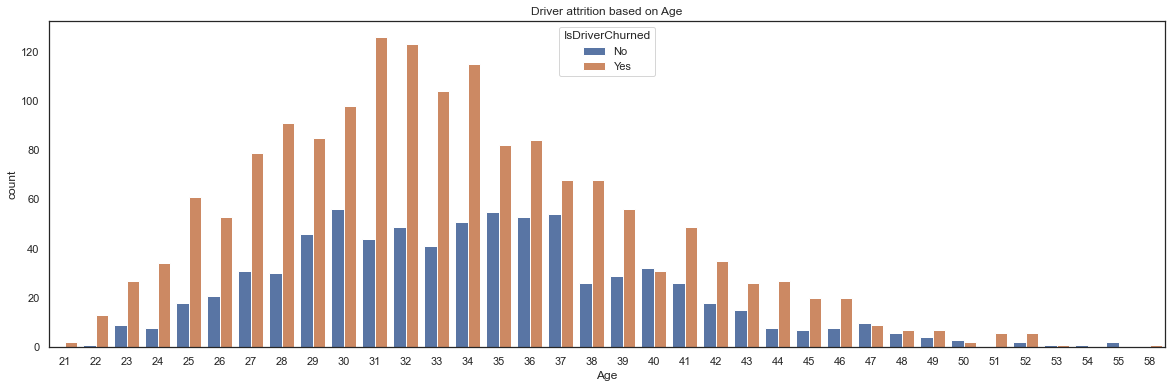

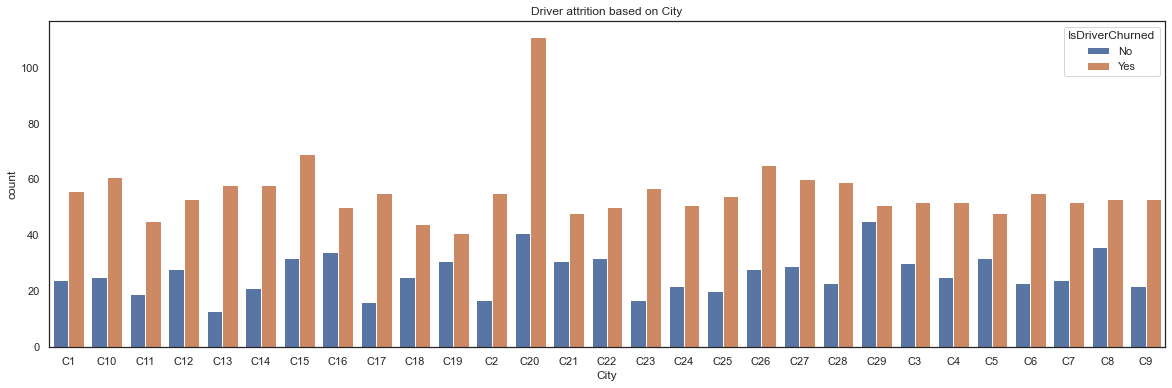

In [63]:
for col in ['Age', 'City']:
    CountPlot(col, figsize = (20,6))

* In terms of city, C20, C26, C15 has highest percentage while C29 is lower.
* Drivers whose age between 30 to 36 having higher percentage of leaving the company.The employees whose age is in the 20-35 or 50-65 groups are less likely to leave the organization.

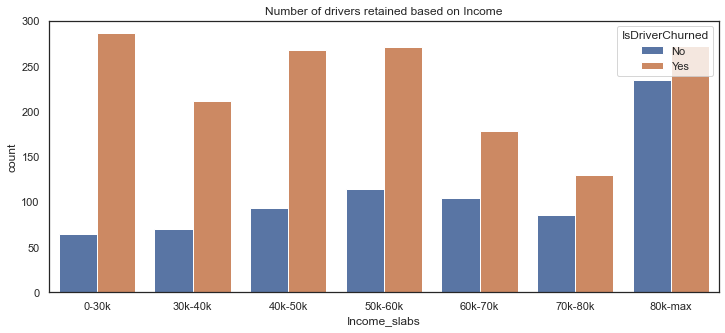

In [64]:
plt.figure(figsize=(12,5))
sns.countplot(x = data['Income_slabs'], hue = data['IsDriverChurned']).set(title ='Number of drivers retained based on Income')
plt.show()

* Increasing Income Level is propotional to driver who are not leaving the company.
* The employees whose monthly income is in 1,60,000-1,90,000 or 1,30,000-1,60,000 are less likely to leave the organization.

[Text(0.5, 1.0, 'Total Business Value with Driver Attrition Rate')]

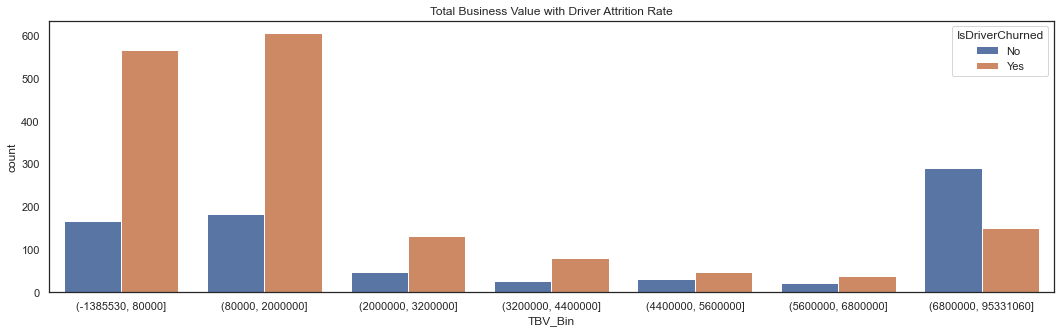

In [65]:
#Defining the bins and groups
m1 = round(data['Total Business Value'].min())
m2 = round(data['Total Business Value'].max())
bins = [m1, 80000 , 2000000 , 3200000, 4400000, 5600000, 6800000, m2]

#Binning the Total Business Value into categories
data['TBV_Bin'] = pd.cut(data['Total Business Value'],bins)

#Total Business Value feature with Target
tbvbin = pd.crosstab(data['TBV_Bin'],data['IsDriverChurned'])
plt.figure(figsize=(18,5))
sns.countplot(x = data['TBV_Bin'], hue = data['IsDriverChurned']).set(title ='Total Business Value with Driver Attrition Rate')


The employees who have acquired total business value greater than 68,00,000 are less likely to leave the organiztion.

In [66]:
data=data.drop(['Income_slabs',"Age_bins",'TBV_Bin'],axis =1)

### **Observations**
- We see a higher churn rate in Male Drivers compared to Female drivers.
- Churn Rate is higher in lower joining designation
- Churn rate is higher in Grade 1 & 2.
- Churn Rate is high in drivers with no increment in quarterly rating.
- Churn Rate is high in drivers with no increment in Income. There seems to be no churn in case of drivers whose salary has seen increment
- Higher Churn rate in drivers with avg. experince of 0, 1 yrs.

## **Multivariate Analysis**

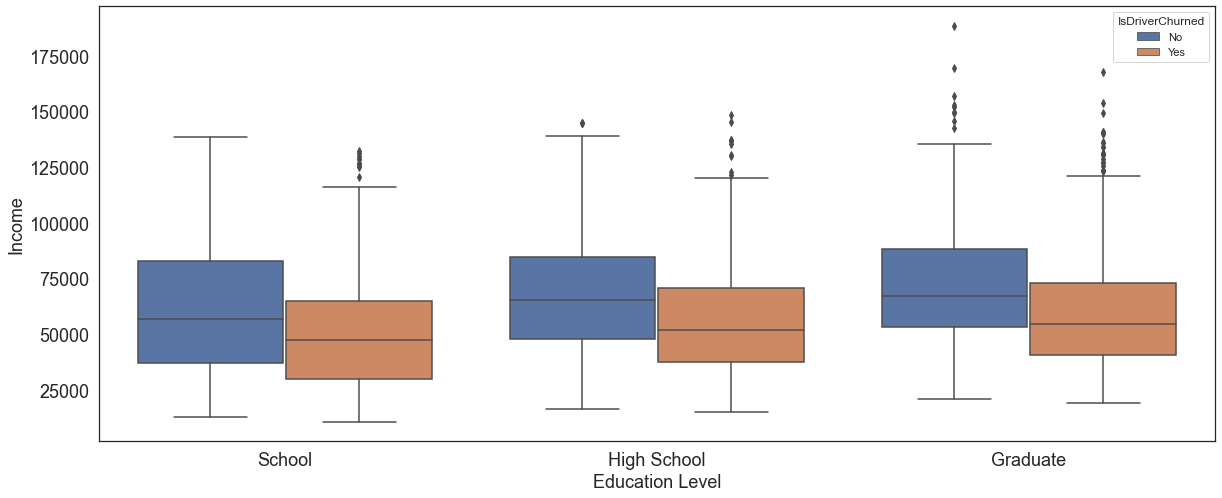

In [67]:
data1 = data.copy()
data1['Education_Level'] = data1['Education_Level'].apply(lambda x: "School" if x == 0 else("High School" if x== 1 else "Graduate"))
plt.figure(figsize = (20,8))
sns.boxplot(data=data1,x = 'Education_Level',y='Income',hue='IsDriverChurned')
plt.xlabel("Education Level",fontsize=18)
plt.ylabel("Income",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

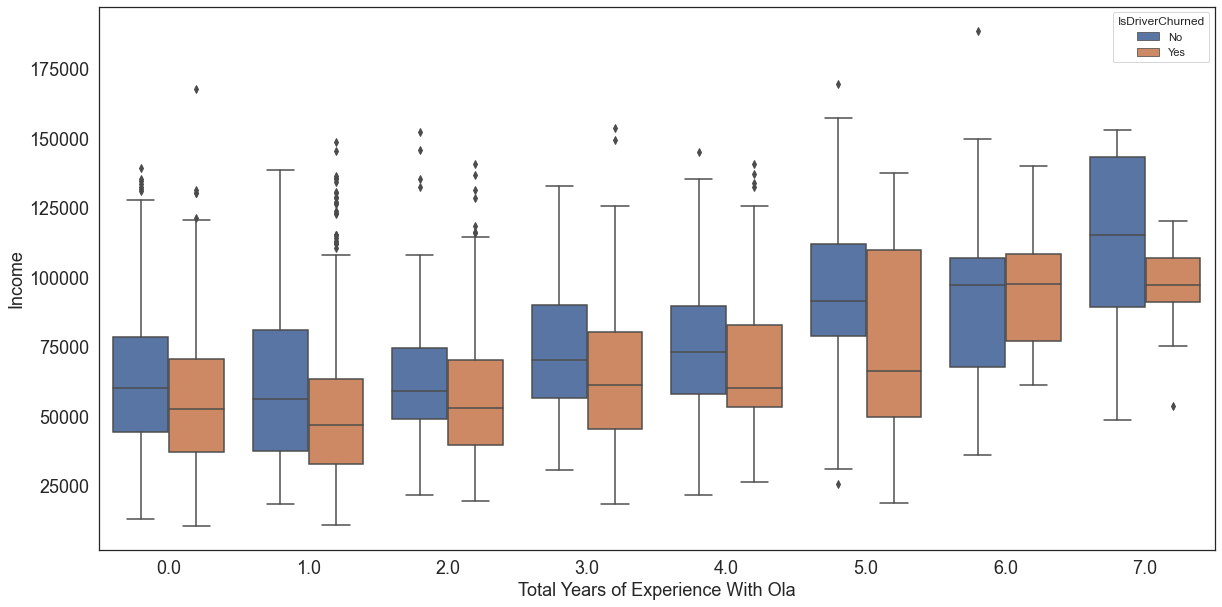

In [68]:
plt.figure(figsize = (20,10))
sns.boxplot(data=data1,x = 'Total_Yrs_Exp',y='Income',hue='IsDriverChurned')
plt.xlabel("Total Years of Experience With Ola",fontsize=18)
plt.ylabel("Income",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [69]:
data.columns

Index(['Age', 'Gender', 'City', 'Education_Level', 'Joining Designation',
       'Grade', 'Total Business Value', 'Income', 'IncomeLevelStatus',
       'Quarterly Rating', 'QuaterlyRatingStatus', 'Reporting_Year', 'Quarter',
       'Reporting_Month', 'DOJ_month', 'DOJ_year', 'DOJ_day', 'Total_Yrs_Exp',
       'IsDriverChurned'],
      dtype='object')

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Age                   2381 non-null   int64   
 1   Gender                2381 non-null   category
 2   City                  2381 non-null   category
 3   Education_Level       2381 non-null   category
 4   Joining Designation   2381 non-null   category
 5   Grade                 2381 non-null   category
 6   Total Business Value  2381 non-null   int64   
 7   Income                2381 non-null   int64   
 8   IncomeLevelStatus     2381 non-null   category
 9   Quarterly Rating      2381 non-null   category
 10  QuaterlyRatingStatus  2381 non-null   category
 11  Reporting_Year        2381 non-null   category
 12  Quarter               2381 non-null   category
 13  Reporting_Month       2381 non-null   category
 14  DOJ_month             2381 non-null   category
 15  DOJ_

In [71]:
data['IsDriverChurned']= data['IsDriverChurned'].map({'Yes': 0, 'No':1})

In [72]:
cols = ['Age', 'Gender',  'Education_Level', 'Total Business Value', 'Income', 'IncomeLevelStatus','IsDriverChurned',
       'Quarterly Rating', 'QuaterlyRatingStatus', 'Reporting_Year',
       'Reporting_Month', 'DOJ_month', 'DOJ_year', 'DOJ_day', 'Total_Yrs_Exp',]
for col in cols:
    data[col]=data[col].astype('int64')

In [73]:
data.head()

Age  Gender City  Education_Level Joining Designation Grade  \
0   28       0  C23                2                   1     1   
1   31       0   C7                2                   2     2   
2   43       0  C13                2                   2     2   
3   29       0   C9                0                   1     1   
4   31       1  C11                1                   3     3   

   Total Business Value  Income  IncomeLevelStatus  Quarterly Rating  \
0               1715580   57387                  0                 2   
1                     0   67016                  0                 1   
2                350000   65603                  0                 1   
3                120360   46368                  0                 1   
4               1265000   78728                  0                 2   

   QuaterlyRatingStatus  Reporting_Year Quarter  Reporting_Month  DOJ_month  \
0                     0            2019      Q1                3         12   
1                     0            2020      Q4               12         11   
2                     0            2020      Q2                4         12   
3                     0            2019      Q1                3          1   
4                     1            2020      Q4               12          7   

   DOJ_year  DOJ_day  Total_Yrs_Exp  IsDriverChurned  
0      2018       24              1                0  
1      2020        6              0                1  
2      2019        7              1                0  
3      2019        9              0                0  
4      2020       31              0                1

In [74]:
# Find correlations with the target and sort
data_trans = data.copy()
data_trans.drop(['Quarter','Reporting_Year','Reporting_Month', 'DOJ_day'], axis=1,inplace=True)
correlations = data_trans.corr()['IsDriverChurned'].sort_values(ascending=False)
correlations

IsDriverChurned         1.000000
Quarterly Rating        0.510532
QuaterlyRatingStatus    0.405072
Total Business Value    0.379552
Income                  0.201935
DOJ_month               0.134682
Age                     0.078906
DOJ_year                0.078640
Total_Yrs_Exp           0.073029
IncomeLevelStatus       0.072492
Education_Level         0.007953
Gender                 -0.011452
Name: IsDriverChurned, dtype: float64

* With respect to Target ie, Attrition of rider
>* Quarterly_Rating and QuarterlyRating_Increment are highly positive correlated to Attrition rate ie,Lower the values of rating for drivers,more likely for them to leave the company.
>* Total Business value and Income are moderately negative correlated to Churn rate.
>* Gender and Education level are moderately negative correlated to attrition of driver from company.

<AxesSubplot:>

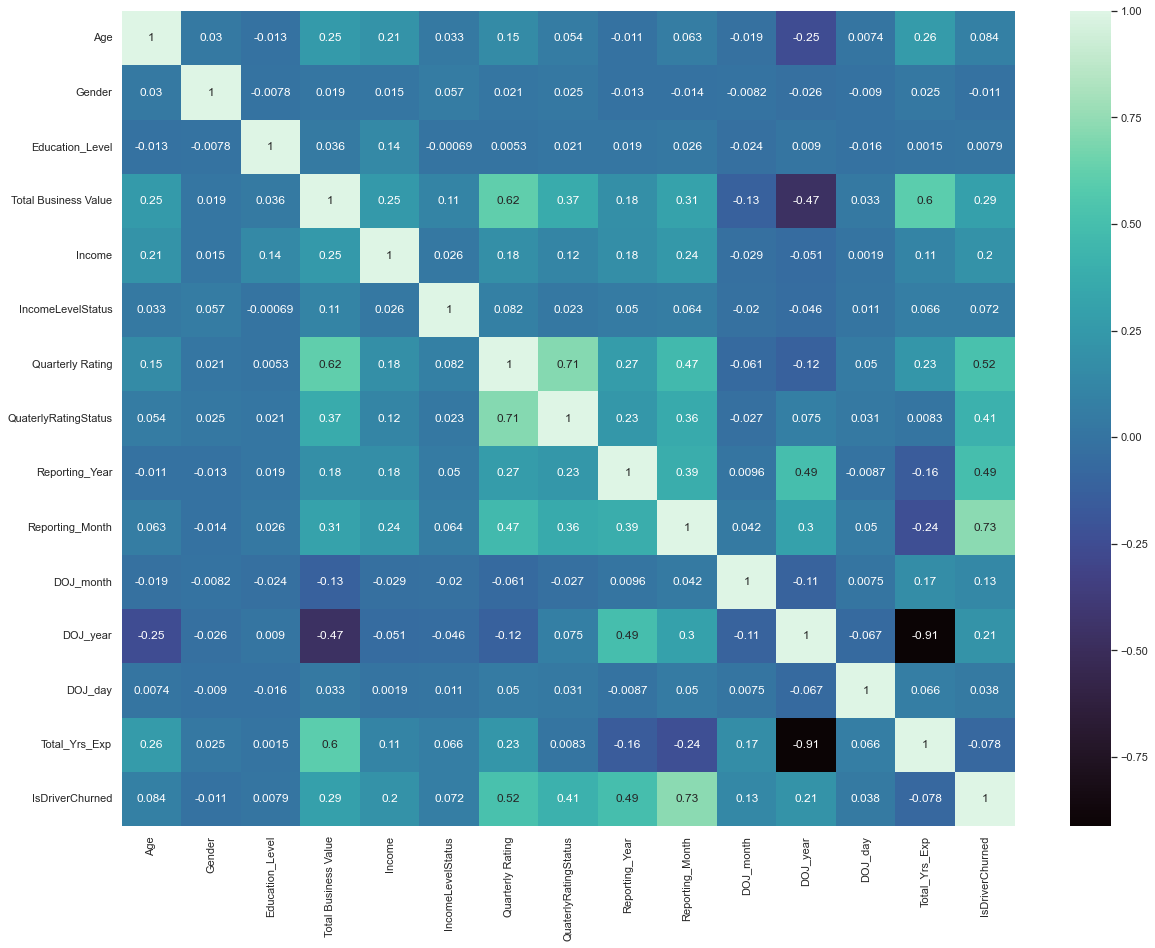

In [75]:
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(method='spearman'),annot=True,cmap ='mako')

### **Observations**
- Pay scale for Male and Female drivers is similar. It can be observed that drivers with lower salary tend to churn
- C11, C23, C14 & C6 seem to be cities with higher churn rate. C12 seem to be cities with high pay for drivers.
- Drivers with School and High School education tend to have a higher churn rate.
- Drivers with Graduate education, tend to have higher salary compared to others.
- Drivers with 5 + years of experience tend to have higher salary.
- Quarterly Rating & Total Business Value has a correlation with target column 'IsDriverChurned'.
- Total Business Value has high correlation with Quarterly Rating. Income has high correlation with Joinining designation and grades.

## **Outlier Treatment**

In [76]:
def outlier_check(df,col_name):

    plt.figure(figsize = (8,4))
    plt.title(f"Boxplot for Outlier Detection for {col_name}")
    plt.ylabel(col_name)
    sns.boxplot(x= df[col_name])
    plt.show()

    print(f"IQR for {col_name}: ")
    print("Finding Lower and Upper IQR Limits: ")
    iqr = np.percentile(df[col_name],75) - np.percentile(df[col_name],25)
    lower_outlier = np.percentile(df[col_name],25) - (1.5*iqr)
    upper_outlier = np.percentile(df[col_name],75) + (1.5*iqr)
    print(f' *  Upper Outlier Limit: {upper_outlier}')
    print(f' *  Lower Outlier Limit: {lower_outlier}')
    print("--"*50)

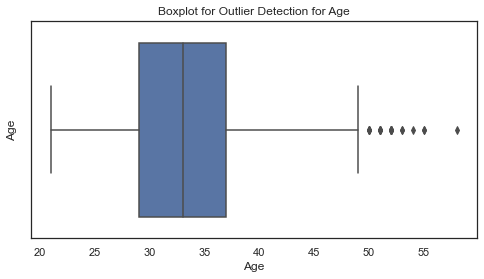

IQR for Age: 
Finding Lower and Upper IQR Limits: 
 *  Upper Outlier Limit: 49.0
 *  Lower Outlier Limit: 17.0
----------------------------------------------------------------------------------------------------


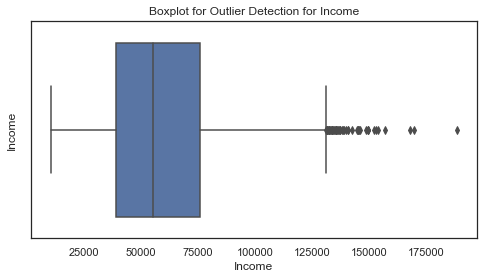

IQR for Income: 
Finding Lower and Upper IQR Limits: 
 *  Upper Outlier Limit: 131309.0
 *  Lower Outlier Limit: -16219.0
----------------------------------------------------------------------------------------------------


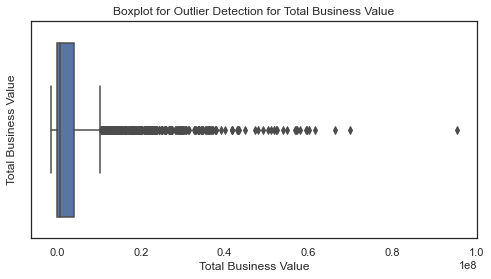

IQR for Total Business Value: 
Finding Lower and Upper IQR Limits: 
 *  Upper Outlier Limit: 10434125.0
 *  Lower Outlier Limit: -6260475.0
----------------------------------------------------------------------------------------------------


In [77]:
out_feature = ["Age","Income","Total Business Value"]

for i in out_feature:
    outlier_check(data,i)

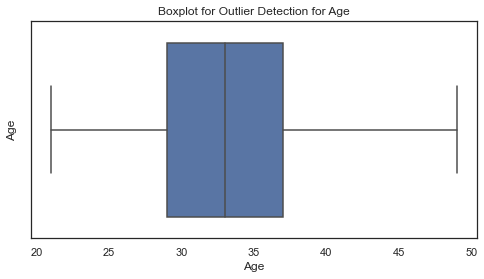

IQR for Age: 
Finding Lower and Upper IQR Limits: 
 *  Upper Outlier Limit: 49.0
 *  Lower Outlier Limit: 17.0
----------------------------------------------------------------------------------------------------


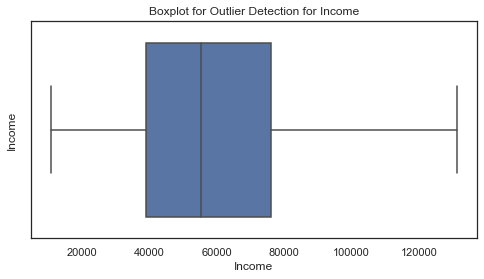

IQR for Income: 
Finding Lower and Upper IQR Limits: 
 *  Upper Outlier Limit: 131309.0
 *  Lower Outlier Limit: -16219.0
----------------------------------------------------------------------------------------------------


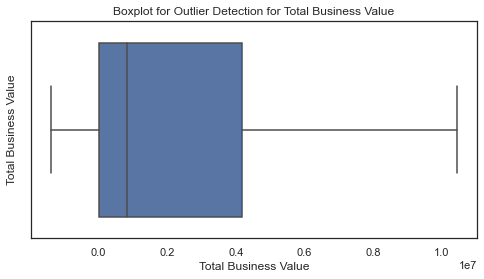

IQR for Total Business Value: 
Finding Lower and Upper IQR Limits: 
 *  Upper Outlier Limit: 10434125.0
 *  Lower Outlier Limit: -6260475.0
----------------------------------------------------------------------------------------------------


In [78]:
def outlier_treatment(df,col_name):
    iqr = np.percentile(df[col_name],75) - np.percentile(df[col_name],25)
    lower_outlier = np.percentile(df[col_name],25) - (1.5*iqr)
    upper_outlier = np.percentile(df[col_name],75) + (1.5*iqr)


    return np.clip(df[col_name], lower_outlier, upper_outlier)


for i in out_feature:
    data[i] = outlier_treatment(data,i)


for i in out_feature:
    outlier_check(data,i)

## Data Preparation for Model Building

In [79]:
data.head()

Age  Gender City  Education_Level Joining Designation Grade  \
0  28.0       0  C23                2                   1     1   
1  31.0       0   C7                2                   2     2   
2  43.0       0  C13                2                   2     2   
3  29.0       0   C9                0                   1     1   
4  31.0       1  C11                1                   3     3   

   Total Business Value   Income  IncomeLevelStatus  Quarterly Rating  \
0             1715580.0  57387.0                  0                 2   
1                   0.0  67016.0                  0                 1   
2              350000.0  65603.0                  0                 1   
3              120360.0  46368.0                  0                 1   
4             1265000.0  78728.0                  0                 2   

   QuaterlyRatingStatus  Reporting_Year Quarter  Reporting_Month  DOJ_month  \
0                     0            2019      Q1                3         12   
1                     0            2020      Q4               12         11   
2                     0            2020      Q2                4         12   
3                     0            2019      Q1                3          1   
4                     1            2020      Q4               12          7   

   DOJ_year  DOJ_day  Total_Yrs_Exp  IsDriverChurned  
0      2018       24              1                0  
1      2020        6              0                1  
2      2019        7              1                0  
3      2019        9              0                0  
4      2020       31              0                1

In [80]:
df_new = data.copy()
df_new.drop(['IncomeLevelStatus','Quarter','Reporting_Year','Reporting_Month', 'DOJ_day'], axis=1,inplace=True)
cols = list(df_new.columns)
cols.remove("IsDriverChurned")

In [81]:
df_new_columns = ['Age', 'Gender', 'Total Business Value', 'Income', 'Quarterly Rating','Grade','QuaterlyRatingStatus',
                  'Joining Designation','DOJ_month', 'DOJ_year','Total_Yrs_Exp', 'IsDriverChurned']
for col in df_new_columns:
    df_new[col] = df_new[col].astype('int64')

In [82]:
df_new.head()

Age  Gender City  Education_Level  Joining Designation  Grade  \
0   28       0  C23                2                    1      1   
1   31       0   C7                2                    2      2   
2   43       0  C13                2                    2      2   
3   29       0   C9                0                    1      1   
4   31       1  C11                1                    3      3   

   Total Business Value  Income  Quarterly Rating  QuaterlyRatingStatus  \
0               1715580   57387                 2                     0   
1                     0   67016                 1                     0   
2                350000   65603                 1                     0   
3                120360   46368                 1                     0   
4               1265000   78728                 2                     1   

   DOJ_month  DOJ_year  Total_Yrs_Exp  IsDriverChurned  
0         12      2018              1                0  
1         11      2020              0                1  
2         12      2019              1                0  
3          1      2019              0                0  
4          7      2020              0                1

### Scaling the numerical features by Standardization

In [83]:
# scaling the numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# column names are (annoyingly) lost after Scaling (i.e. the dataframe is converted to a numpy ndarray)
numerical = df_new.select_dtypes(include=['int64']).drop('IsDriverChurned',axis=1)
df_num = pd.DataFrame(scaler.fit_transform(numerical),columns = numerical.columns)
df_num.head()

Age    Gender  Education_Level  Joining Designation     Grade  \
0 -0.959529 -0.832740         1.216049            -0.975022 -1.158317   
1 -0.449299 -0.832740         1.216049             0.213676 -0.084348   
2  1.591619 -0.832740         1.216049             0.213676 -0.084348   
3 -0.789452 -0.832740        -1.234575            -0.975022 -1.158317   
4 -0.449299  1.200854        -0.009263             1.402374  0.989621   

   Total Business Value    Income  Quarterly Rating  QuaterlyRatingStatus  \
0             -0.282366 -0.062677          0.706497             -0.420672   
1             -0.740815  0.284163         -0.528576             -0.420672   
2             -0.647285  0.233266         -0.528576             -0.420672   
3             -0.708651 -0.459586         -0.528576             -0.420672   
4             -0.402773  0.706033          0.706497              2.377149   

   DOJ_month  DOJ_year  Total_Yrs_Exp  
0   1.477363 -0.333277      -0.072501  
1   1.159143  0.909531      -0.726387  
2   1.477363  0.288127      -0.072501  
3  -2.023054  0.288127      -0.726387  
4  -0.113736  0.909531      -0.726387

### **Encoding of categorical variables**

In [84]:
# Encoding the categorical features

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse=False)

# column names are (annoyingly) lost after OneHotEncoding  (i.e. the dataframe is converted to a numpy ndarray)
categorical = df_new.select_dtypes(include=['category'])
df_cat = pd.DataFrame(encoder.fit_transform(categorical), columns=encoder.get_feature_names(categorical.columns))

In [85]:
df_final = pd.concat([df_num, df_cat,df_new['IsDriverChurned']], axis=1)
df_final.head()

Age    Gender  Education_Level  Joining Designation     Grade  \
0 -0.959529 -0.832740         1.216049            -0.975022 -1.158317   
1 -0.449299 -0.832740         1.216049             0.213676 -0.084348   
2  1.591619 -0.832740         1.216049             0.213676 -0.084348   
3 -0.789452 -0.832740        -1.234575            -0.975022 -1.158317   
4 -0.449299  1.200854        -0.009263             1.402374  0.989621   

   Total Business Value    Income  Quarterly Rating  QuaterlyRatingStatus  \
0             -0.282366 -0.062677          0.706497             -0.420672   
1             -0.740815  0.284163         -0.528576             -0.420672   
2             -0.647285  0.233266         -0.528576             -0.420672   
3             -0.708651 -0.459586         -0.528576             -0.420672   
4             -0.402773  0.706033          0.706497              2.377149   

   DOJ_month  DOJ_year  Total_Yrs_Exp  City_C10  City_C11  City_C12  City_C13  \
0   1.477363 -0.333277      -0.072501       0.0       0.0       0.0       0.0   
1   1.159143  0.909531      -0.726387       0.0       0.0       0.0       0.0   
2   1.477363  0.288127      -0.072501       0.0       0.0       0.0       1.0   
3  -2.023054  0.288127      -0.726387       0.0       0.0       0.0       0.0   
4  -0.113736  0.909531      -0.726387       0.0       1.0       0.0       0.0   

   City_C14  City_C15  City_C16  City_C17  City_C18  City_C19  City_C2  \
0       0.0       0.0       0.0       0.0       0.0       0.0      0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0      0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0      0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0      0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0      0.0   

   City_C20  City_C21  City_C22  City_C23  City_C24  City_C25  City_C26  \
0       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   City_C27  City_C28  City_C29  City_C3  City_C4  City_C5  City_C6  City_C7  \
0       0.0       0.0       0.0      0.0      0.0      0.0      0.0      0.0   
1       0.0       0.0       0.0      0.0      0.0      0.0      0.0      1.0   
2       0.0       0.0       0.0      0.0      0.0      0.0      0.0      0.0   
3       0.0       0.0       0.0      0.0      0.0      0.0      0.0      0.0   
4       0.0       0.0       0.0      0.0      0.0      0.0      0.0      0.0   

   City_C8  City_C9  IsDriverChurned  
0      0.0      0.0                0  
1      0.0      0.0                1  
2      0.0      0.0                0  
3      0.0      1.0                0  
4      0.0      0.0                1

### **Model Building**

In [86]:
y = df_final.loc[:,'IsDriverChurned']
X = df_final.drop(['IsDriverChurned'],axis=1)

In [87]:
# Printing the percentage of row count per class label
print(y.value_counts(normalize=True).round(3).mul(100))
print("-"*80)
# Printing the value counts
print(y.value_counts())

0    67.9
1    32.1
Name: IsDriverChurned, dtype: float64
--------------------------------------------------------------------------------
0    1616
1     765
Name: IsDriverChurned, dtype: int64


**NOTE :**
* **Imbalanced data for analysis**

We see there is an imbalanced class problem. Indeed, the percentage of Current Employees in our dataset is 32% and the percentage of Ex-employees is: 68% ie, The imbalance ratio Class 0: Class 1 is almost 1:2.

Machine learning algorithms typically work best when the number of instances of each classes are roughly equal. We will have to address this target feature imbalance prior to implementing our Machine Learning algorithms.

#### **We deal the imbalance in data with Class Imbalance Treatment using class_weights**

* **Using F1 Score as the Model Evaluation Metric**

The area of interest is clearly on riders with high attrition risks. Employees who are deemed to have no attrition risks are not the key focus of this analysis. As such, the model evaluation metric should not be centered on the Accuracy Score in the Confusion Matrix.Instead,here we use F1 Score, which focuses on Class 1 of the Classification outcome, as the key model evaluation metric while comparing across the different classification techniques using ensemble learning methodology.

* We also perform **hyperparameter tuning to find best parameters using GridSearch** to optimise the performance of the model.

In [88]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [89]:
# Train, CV, test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size=0.8, random_state=1221)
X_valid, X_test, y_valid, y_test = train_test_split(X_val,y_val, test_size=0.5, random_state=1221)

In [90]:
print("Train : ",X_train.shape,y_train.shape)
print("validation :",X_valid.shape,y_valid.shape)
print("Test :",X_test.shape,y_test.shape)

Train :  (1904, 40) (1904,)
validation : (238, 40) (238,)
Test : (239, 40) (239,)


In [91]:
#Median Imputing
tbv_util_median = X_train['Total Business Value'].median()
#Imputing Train, Val & Test data
X_train.loc[ X_train['Total Business Value'] == 0, 'Total Business Value' ] = tbv_util_median
X_val.loc[ X_val['Total Business Value'] == 0, 'Total Business Value' ] = tbv_util_median
X_test.loc[ X_test['Total Business Value'] == 0, 'Total Business Value' ] = tbv_util_median

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## **Bagging Method  - Random Forest**
 -- Imbalance Treatment using class weights

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import pprint
pp = pprint.PrettyPrinter(indent=4)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 9,num=7)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'min_samples_split': min_samples_split,
 'min_samples_leaf': min_samples_leaf,
 'bootstrap': bootstrap,
 }
pp.pprint(random_grid)

{   'bootstrap': [True, False],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [94]:
rf_classifier = RandomForestClassifier(class_weight={0:.3,1:.7})
rf_random = RandomizedSearchCV(estimator = rf_classifier, param_distributions = random_grid,
                             n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}


In [95]:
base_model = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, max_features='sqrt',
                        max_depth=8,bootstrap=True, class_weight={0:.3,1:.7})
base_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=8,
                       n_estimators=1000)

Classification Report
-------------------------
              precision    recall  f1-score   support

       Churn       0.97      0.90      0.93       171
      Retain       0.79      0.93      0.85        68

    accuracy                           0.91       239
   macro avg       0.88      0.91      0.89       239
weighted avg       0.92      0.91      0.91       239

________________________________________________________________________________
Performance metrics
-------------------------
Precision: 0.788
Recall: 0.926
F1 score : 0.851


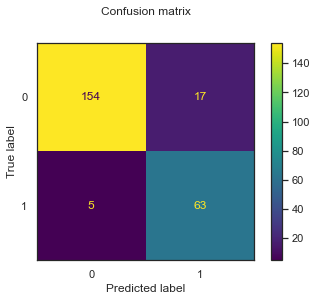

In [96]:
print("Classification Report")
print("-"*25)
Y_pred = base_model.predict(X_test)
print(f"{classification_report(y_test,Y_pred, target_names=['Churn','Retain'])}")
print("_"*80)
print("Performance metrics")
print("-"*25)
Precision = precision_score(y_test,Y_pred).round(3)
Recall = recall_score(y_test, Y_pred).round(3)
F1score = f1_score(y_test, Y_pred).round(3)
print('Precision:', Precision)
print('Recall:', Recall)
print("F1 score :",F1score)


confusion = confusion_matrix(y_test,Y_pred)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion).plot()
plt.title('Confusion matrix', y=1.1)
plt.show()


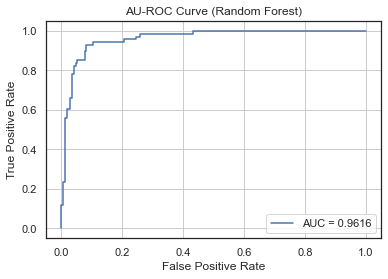

In [97]:
y_pred_proba = base_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(4)
#create ROC curve
plt.plot(fpr,tpr,label="AUC = "+ str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.grid()
plt.title("AU-ROC Curve (Random Forest)")
plt.show()


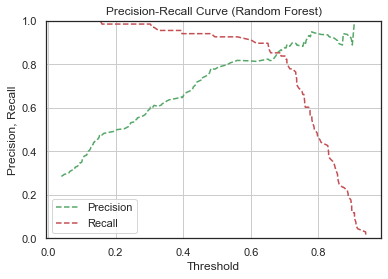

In [98]:
from sklearn.metrics import precision_recall_curve
probs_y=base_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1])
plt.title("Precision-Recall Curve (Random Forest)")
plt.plot(thresholds, precision[: -1], "g--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.grid()
plt.show()


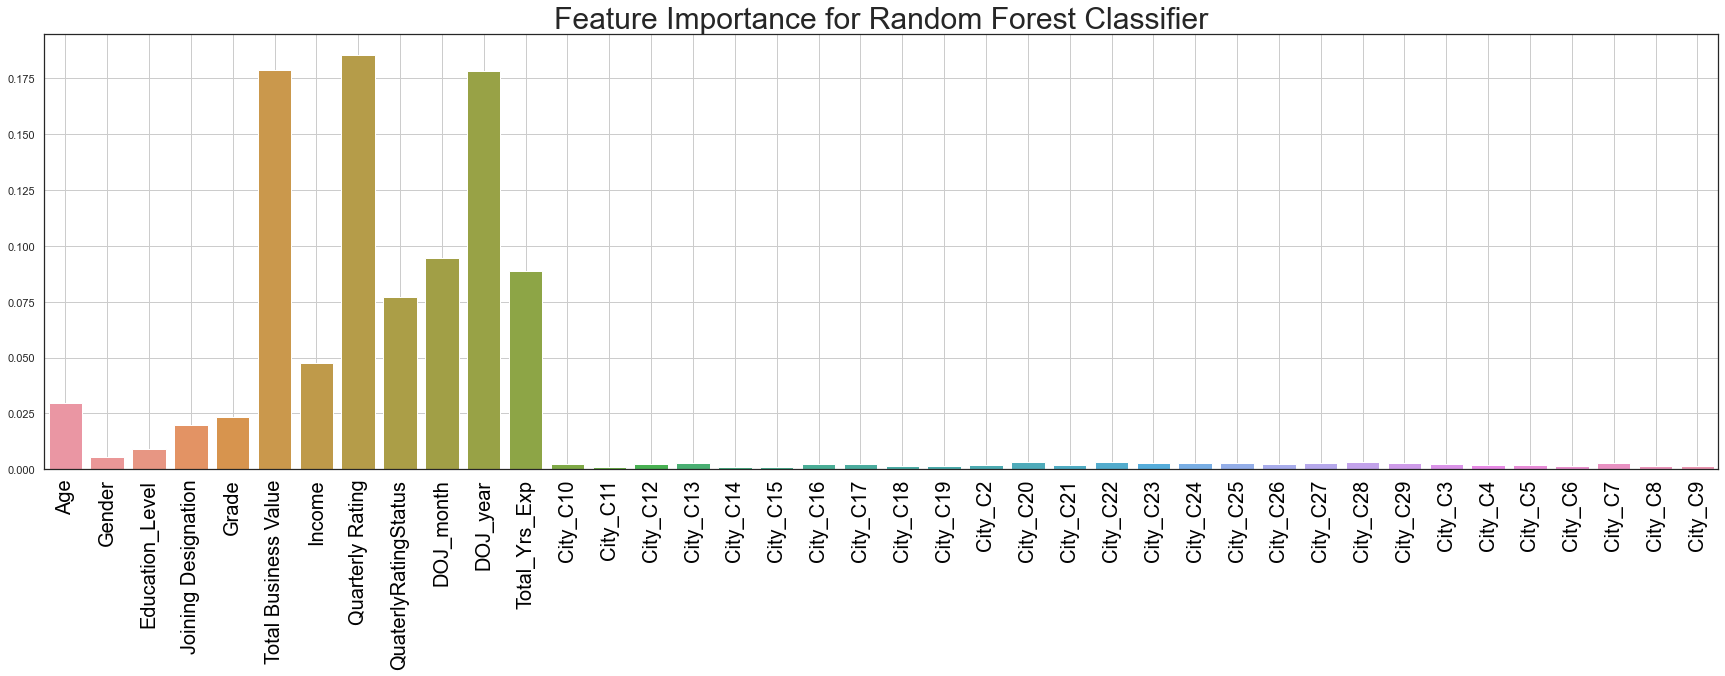

In [99]:
#Feature Importance
plt.figure(figsize=(30,8))
plt.title("Feature Importance for Random Forest Classifier",fontsize = 30) # Create plot title
sns.barplot(x = X_train.columns,y = base_model.feature_importances_)
plt.xticks(rotation=90,color="black",fontsize = 20)
plt.grid()
plt.show()


### **Observations**
* Random Forests combines the prediction of mutliple deep decision trees using the Bootstrapped Aggregation (bagging) technique.
* Model is **Random Forest classifier with class weights** considering imbalanced dataset.
* Best Hyperparameters are 'max_depth'= 5 and 'n_estimators'= 1000
* The **F1 score** for predicting churn is 0.92 and retention is 0.82.
* The **Precision** for predicting churn is 93% and retention is 80%
* The **Recall** for predicting leaving the company is 93% and retention is 85%
* The AUC score for predicting leaving the company is 0.961

* The top 3 most important features that has high impact on predict the driver churned are :
>* Quaterly Rating
>* Total Business Value
>* Income
>* Total years of experience



### **Boosting Method - Gradient Boosting DT**

> Data Imbalance treated using class weights

In [101]:
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold 
import datetime as dt


params = { 'learning_rate': [0.1,0.4, 0.6, 0.8], 
            'subsample': [0.6, 0.8, 1.0], 
            'max_depth': [3, 4, 5,6],
        'n_estimators':[50,100,150,200,250]}

gb = GBDT()
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(gb, param_distributions=params, n_iter=10, scoring='f1', n_jobs=4, 
                                   cv=skf.split(X_train,y_train), random_state=1001 )
random_search.fit(X_train, y_train)
print("Best parameters :",random_search.best_params_)


Best parameters : {'subsample': 0.8, 'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.1}


In [102]:
## Training the model using the best hyperparameters

gb = GBDT(subsample=0.8, n_estimators=250, max_depth=3, learning_rate= 0.1)
gb.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=250, subsample=0.8)

Classification Report
-------------------------
              precision    recall  f1-score   support

       Churn       0.95      0.91      0.93       171
      Retain       0.79      0.88      0.83        68

    accuracy                           0.90       239
   macro avg       0.87      0.89      0.88       239
weighted avg       0.90      0.90      0.90       239

________________________________________________________________________________
Performance metrics
-------------------------
Precision: 0.789
Recall: 0.882
F1 score : 0.833


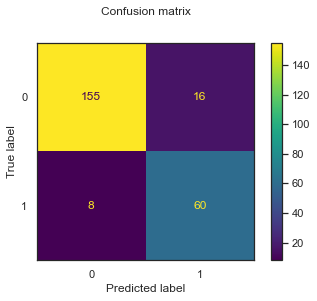

In [103]:
print("Classification Report")
print("-"*25)
Y_pred = gb.predict(X_test)
print(f"{classification_report(y_test,Y_pred, target_names=['Churn','Retain'])}")
print("_"*80)
print("Performance metrics")
print("-"*25)
Precision = precision_score(y_test,Y_pred).round(3)
Recall = recall_score(y_test, Y_pred).round(3)
F1score = f1_score(y_test, Y_pred).round(3)
print('Precision:', Precision)
print('Recall:', Recall)
print("F1 score :",F1score)


confusion = confusion_matrix(y_test,Y_pred)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion).plot()
plt.title('Confusion matrix', y=1.1)
plt.show()


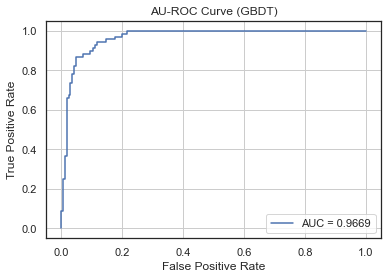

In [104]:
y_pred_proba = gb.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(4)
#create ROC curve
plt.plot(fpr,tpr,label="AUC = "+ str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.grid()
plt.title("AU-ROC Curve (GBDT)")
plt.show()

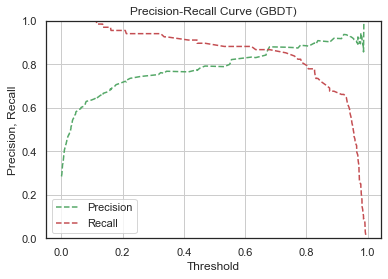

In [105]:
from sklearn.metrics import precision_recall_curve
probs_y=gb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1])
plt.title("Precision-Recall Curve (GBDT)")
plt.plot(thresholds, precision[: -1], "g--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.grid()
plt.show()

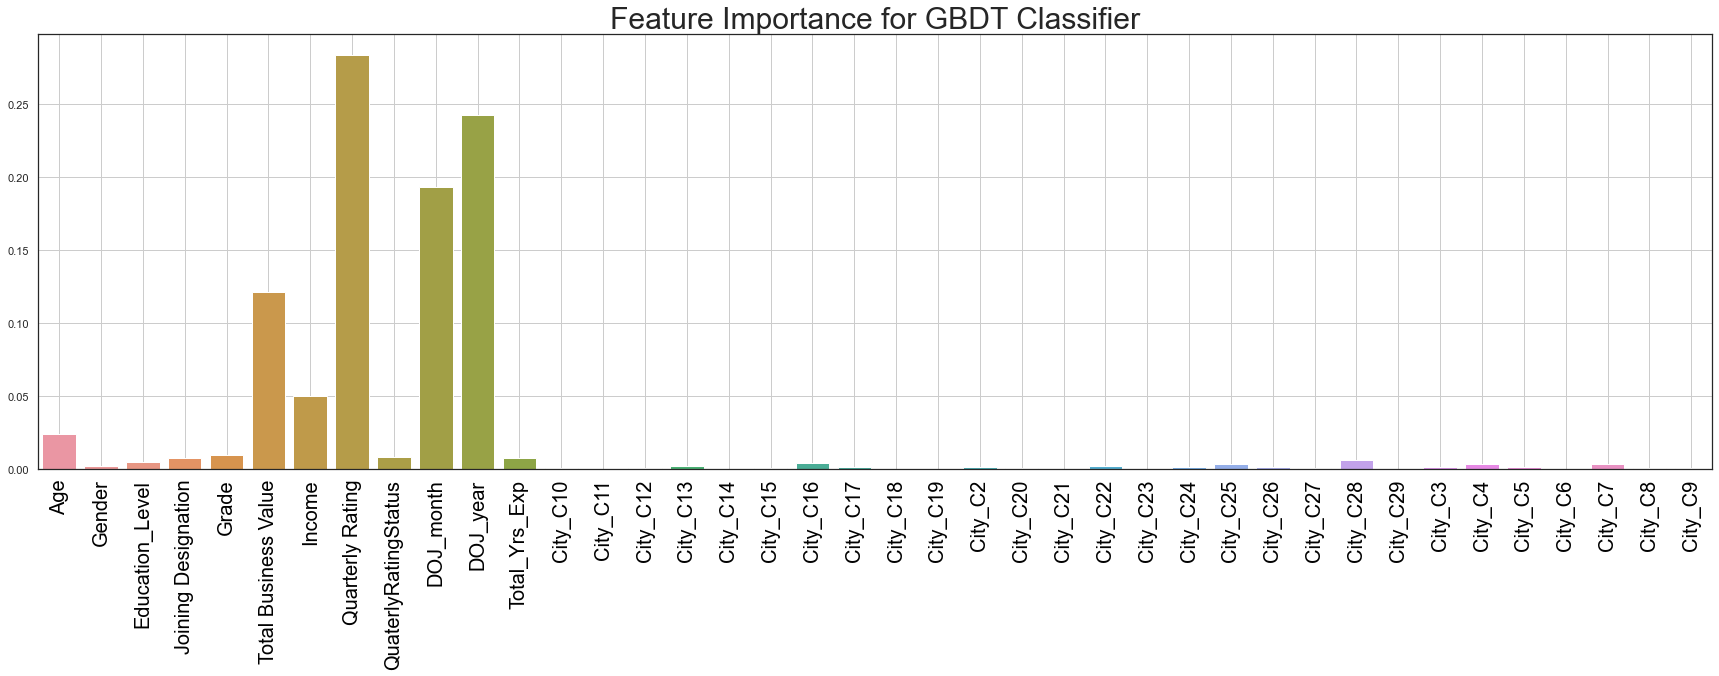

In [106]:
#Feature Importance
plt.figure(figsize=(30,8))
plt.title("Feature Importance for GBDT Classifier",fontsize = 30) # Create plot title
sns.barplot(x = X_train.columns,y = gb.feature_importances_)
plt.xticks(rotation=90,color="black",fontsize = 20)
plt.grid()
plt.show()

### **Observations**

* Model is **Gradient Boosting classifier**
* Best Hyperparameters are 'subsample': 0.8, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1
* The **F1 score** for predicting churn is 0.92 and retention is 0.82. 
* The **Recall** score for predicting churn is 0.89 and retention is 0.88
* The **Precision** score for predicting leaving the company is 0.95 and retention is 0.76
* The AUC score for predicting leaving the company is 0.9708

* The topmost important features are:
>* Quaterly Rating
>* Total Business Value
>* Income
>* Joining Year And Month

## Boosting Method - XGBoost
-- Class imbalance treated using class weights

In [107]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import datetime as dt
params = { 'learning_rate': [0.1, 0.4,0.6, 0.8],   # shrinkage coefficient - "v" [0,1]
        'subsample': [0.6, 0.8, 1.0],     # concept of bagging in xgboost- row sampling
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'n_estimators':[50,100,150,200,250]}

xgb = XGBClassifier(class_weight = "balanced")
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='f1', n_jobs=4, 
                                   cv=skf.split(X_train,y_train), random_state=1001 )
random_search.fit(X_train, y_train)
print("Best Parameters :",random_search.best_params_)

[11:32:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

Best Parameters : {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [108]:
## Training the model using the best hyperparameters
xgb = XGBClassifier(n_estimators=50,subsample=1.0, max_depth=5, learning_rate=0.1, colsample_bytree=0.6)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Classification Report
-------------------------
              precision    recall  f1-score   support

       Churn       0.97      0.91      0.94       171
      Retain       0.81      0.93      0.86        68

    accuracy                           0.92       239
   macro avg       0.89      0.92      0.90       239
weighted avg       0.92      0.92      0.92       239

________________________________________________________________________________
Performance metrics
-------------------------
Precision: 0.808
Recall: 0.926
F1 score : 0.863


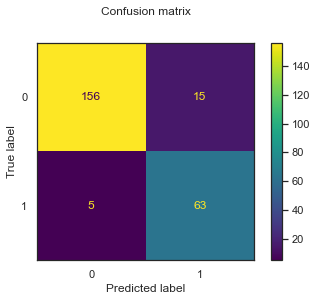

In [109]:

print("Classification Report")
print("-"*25)
Y_pred = xgb.predict(X_test)
print(f"{classification_report(y_test,Y_pred, target_names=['Churn','Retain'])}")
print("_"*80)
print("Performance metrics")
print("-"*25)
Precision = precision_score(y_test,Y_pred).round(3)
Recall = recall_score(y_test, Y_pred).round(3)
F1score = f1_score(y_test, Y_pred).round(3)
print('Precision:', Precision)
print('Recall:', Recall)
print("F1 score :",F1score)


confusion = confusion_matrix(y_test,Y_pred)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion).plot()
plt.title('Confusion matrix', y=1.1)
plt.show()

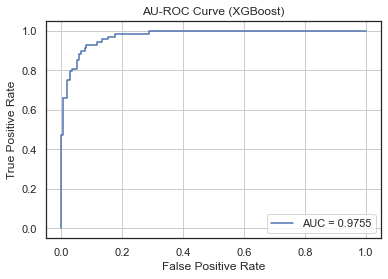

In [110]:
y_pred_proba = xgb.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(4)
#create ROC curve
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.grid()
plt.title("AU-ROC Curve (XGBoost)")
plt.show()

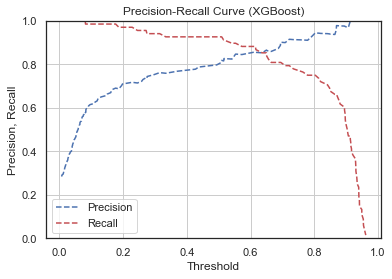

In [111]:
from sklearn.metrics import precision_recall_curve
probs_y=xgb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1])
plt.title("Precision-Recall Curve (XGBoost)")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.grid()
plt.show()

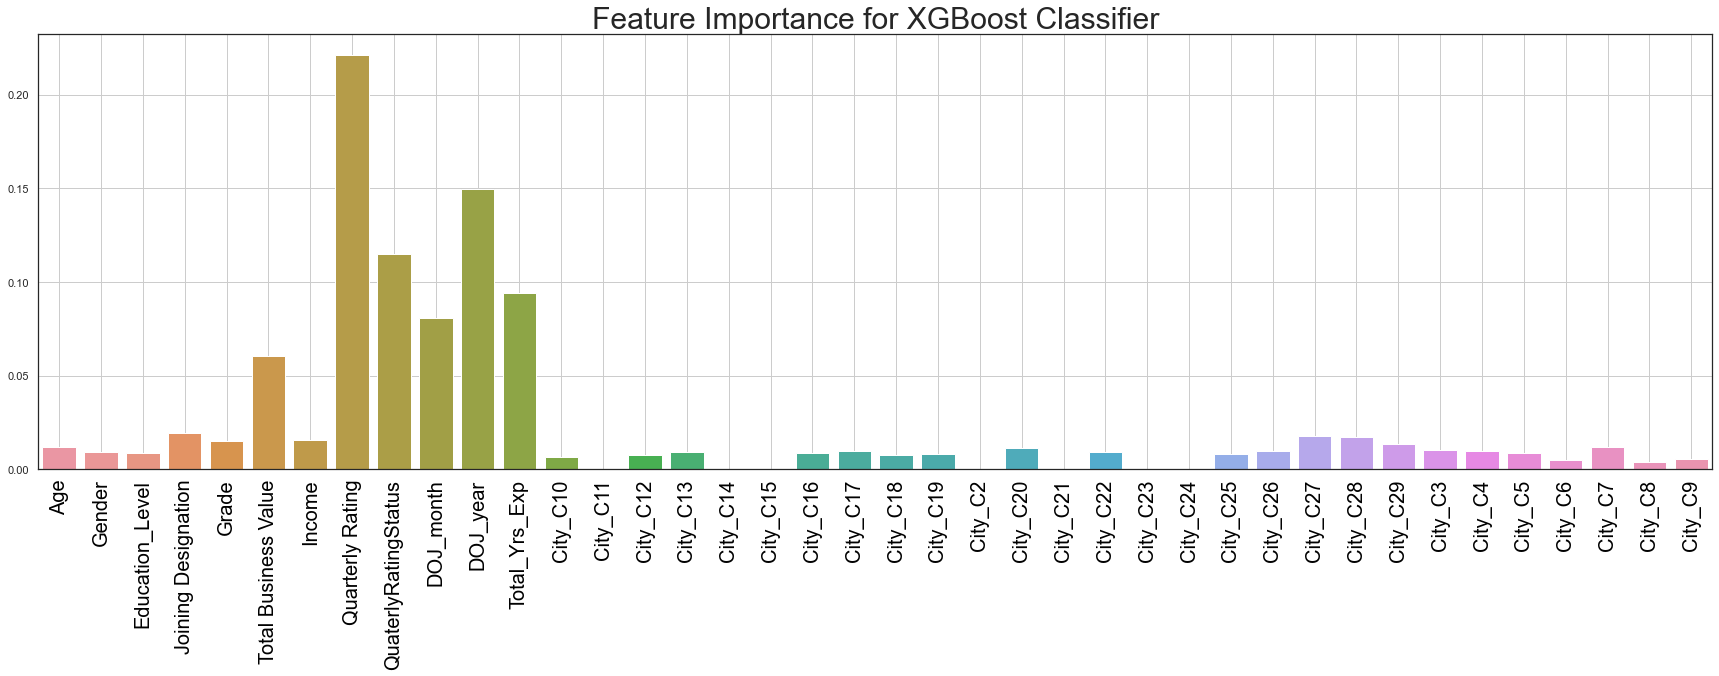

In [112]:
#Feature Importance
plt.figure(figsize=(30,8))
plt.title("Feature Importance for XGBoost Classifier",fontsize = 30) # Create plot title
sns.barplot(x = X_train.columns,y = xgb.feature_importances_)
plt.xticks(rotation=90,color="black",fontsize=20)
plt.grid()
plt.show()

### **Observations**

* Model is **XGB classifier**
* Best Hyperparameters are 'subsample': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6
* The **F1 score** for predicting churn is 0.94 and retention is 0.86. 
* The **Recall** score for predicting churn is 0.93 and retention is 0.91
* The **Precision** score for predicting leaving the company is 0.97 and retention is 0.81
* The AUC score for predicting leaving the company is 0.9755

* The topmost important features are:
>* Quaterly Rating
>* Joining Designation
>* Total Business Value
>* Grade

## **Result Evaluation for Imbalance Treatment using Class Weights**

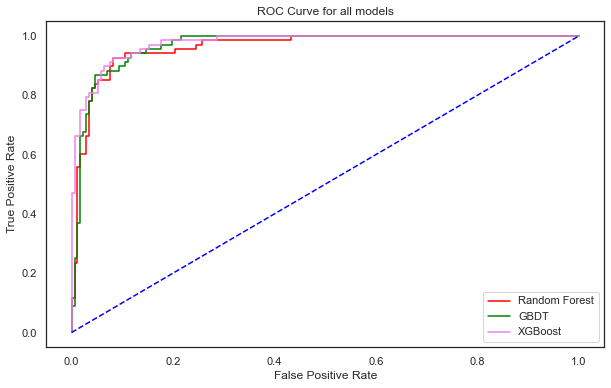

ROC - AUC score for different models using class weights: 
* Random Forest: 96.16
* GBDT: 96.69
* XGBoost: 97.55
--------------------------------------------------------------------------------
F1 score for different models using class weights: 
*  Random Forest: 85.135
*  GBDT : 83.333
*  XGBoost : 86.301


In [139]:
# Plot ROC Curve of three models
from sklearn.metrics import roc_curve


rf_y_test_pred_proba = base_model.predict_proba(X_test)[:,1]
gb_y_test_pred_proba = gb.predict_proba(X_test)[::,1]
xgb_y_test_pred_proba = xgb.predict_proba(X_test)[:,1]

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_y_test_pred_proba)
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb_y_test_pred_proba)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_y_test_pred_proba)


# plot TPR against FPR
plt.figure(figsize=(10,6))

rf_plot = plt.plot(rf_fpr, rf_tpr, color='red')
gbt_plot = plt.plot(gb_fpr, gb_tpr, color='green')
xgbt_plot = plt.plot(xgb_fpr, xgb_tpr, color='violet')
plt.legend([ 'Random Forest','GBDT',"XGBoost"],loc='lower right')

# plot 45 degree line
xx = np.linspace(0, 1, 20)
plt.plot(xx, xx, color='blue',linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for all models")
plt.savefig('ROC')
plt.show()

print("ROC - AUC score for different models using class weights: ")
print("* Random Forest:",roc_auc_score(y_test,rf_y_test_pred_proba).round(4)*100)
print("* GBDT:",roc_auc_score(y_test,gb_y_test_pred_proba).round(4)*100)
print("* XGBoost:",roc_auc_score(y_test,xgb_y_test_pred_proba).round(4)*100)

print("-"*80)

print("F1 score for different models using class weights: ")
print("*  Random Forest:" ,f1_score(y_test, base_model.predict(X_test)).round(5)*100)
print("*  GBDT :" ,f1_score(y_test, gb.predict(X_test)).round(5)*100)
print("*  XGBoost :" ,f1_score(y_test, xgb.predict(X_test)).round(5)*100)

## Class Imbalance Treatment using SMOTE

In [115]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
print(y_sm.value_counts())

0    1280
1    1280
Name: IsDriverChurned, dtype: int64


## Bagging Method - Random Forest

In [116]:
# Random Forest
# we apply Smote to train data
rfmodel_sm = RandomForestClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 1, 
                                    max_features='sqrt', max_depth=8,bootstrap=True)

rfmodel_sm.fit(X_sm, y_sm)

RandomForestClassifier(max_depth=8, n_estimators=1000)

Classification Report
-------------------------
              precision    recall  f1-score   support

       Churn       0.96      0.91      0.94       171
      Retain       0.81      0.91      0.86        68

    accuracy                           0.91       239
   macro avg       0.88      0.91      0.90       239
weighted avg       0.92      0.91      0.91       239

________________________________________________________________________________
Performance metrics
-------------------------
Precision: 0.805
Recall: 0.912
F1 score : 0.855


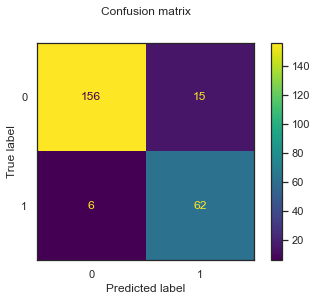

In [117]:
print("Classification Report")
print("-"*25)
Y_pred = rfmodel_sm.predict(X_test)
print(f"{classification_report(y_test,Y_pred, target_names=['Churn','Retain'])}")
print("_"*80)
print("Performance metrics")
print("-"*25)
Precision = precision_score(y_test,Y_pred).round(3)
Recall = recall_score(y_test, Y_pred).round(3)
F1score = f1_score(y_test, Y_pred).round(3)
print('Precision:', Precision)
print('Recall:', Recall)
print("F1 score :",F1score)


confusion = confusion_matrix(y_test,Y_pred)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion).plot()
plt.title('Confusion matrix', y=1.1)
plt.show()


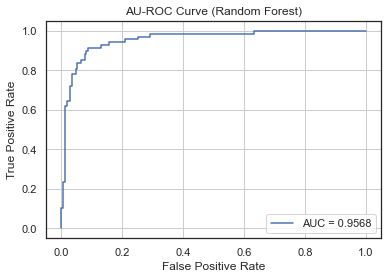

In [118]:
y_pred_proba = rfmodel_sm.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(4)
#create ROC curve
plt.plot(fpr,tpr,label="AUC = "+ str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.grid()
plt.title("AU-ROC Curve (Random Forest)")
plt.show()

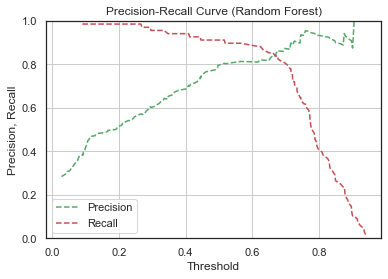

In [119]:
from sklearn.metrics import precision_recall_curve
probs_y=rfmodel_sm.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1])
plt.title("Precision-Recall Curve (Random Forest)")
plt.plot(thresholds, precision[: -1], "g--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.grid()
plt.show()

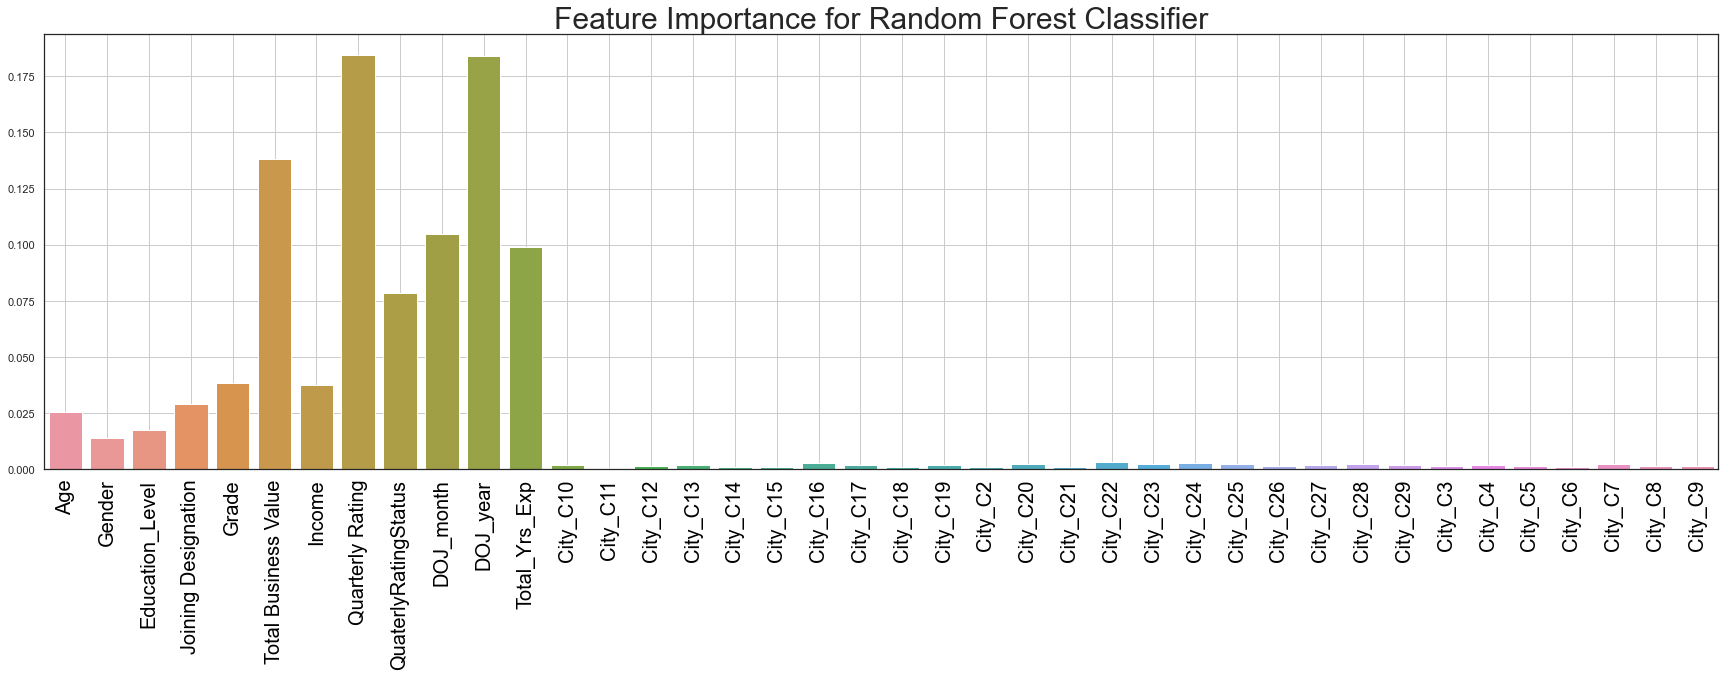

In [120]:
#Feature Importance
plt.figure(figsize=(30,8))
plt.title("Feature Importance for Random Forest Classifier",fontsize = 30) # Create plot title
sns.barplot(x = X_train.columns,y = rfmodel_sm.feature_importances_)
plt.xticks(rotation=90,color="black",fontsize = 20)
plt.grid()
plt.show()

## Boosting Method - Gradient Boosting DT

In [121]:
gbdt_sm = GBDT(subsample=0.8, n_estimators=250, max_depth=3, learning_rate= 0.1)
gbdt_sm.fit(X_sm, y_sm)

GradientBoostingClassifier(n_estimators=250, subsample=0.8)

Classification Report
-------------------------
              precision    recall  f1-score   support

       Churn       0.96      0.91      0.93       171
      Retain       0.79      0.91      0.85        68

    accuracy                           0.91       239
   macro avg       0.88      0.91      0.89       239
weighted avg       0.91      0.91      0.91       239

________________________________________________________________________________
Performance metrics
-------------------------
Precision: 0.795
Recall: 0.912
F1 score : 0.849


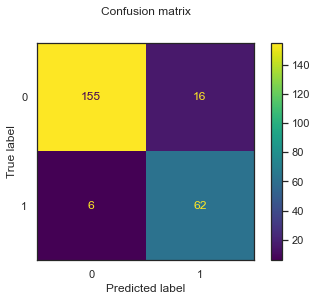

In [122]:
print("Classification Report")
print("-"*25)
Y_pred = gbdt_sm.predict(X_test)
print(f"{classification_report(y_test,Y_pred, target_names=['Churn','Retain'])}")
print("_"*80)
print("Performance metrics")
print("-"*25)
Precision = precision_score(y_test,Y_pred).round(3)
Recall = recall_score(y_test, Y_pred).round(3)
F1score = f1_score(y_test, Y_pred).round(3)
print('Precision:', Precision)
print('Recall:', Recall)
print("F1 score :",F1score)


confusion = confusion_matrix(y_test,Y_pred)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion).plot()
plt.title('Confusion matrix', y=1.1)
plt.show()

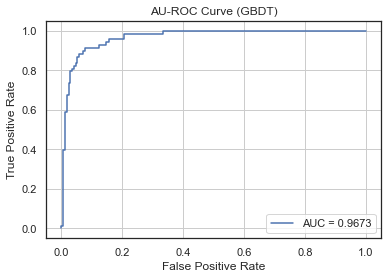

In [125]:
y_pred_proba = gbdt_sm.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(4)
#create ROC curve
plt.plot(fpr,tpr,label="AUC = "+ str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.grid()
plt.title("AU-ROC Curve (GBDT)")
plt.show()

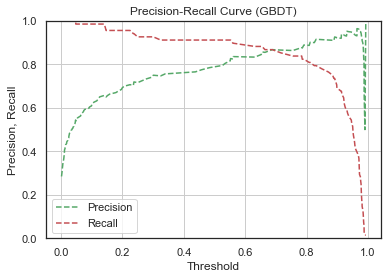

In [126]:
from sklearn.metrics import precision_recall_curve
probs_y=gbdt_sm.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1])
plt.title("Precision-Recall Curve (GBDT)")
plt.plot(thresholds, precision[: -1], "g--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.grid()
plt.show()

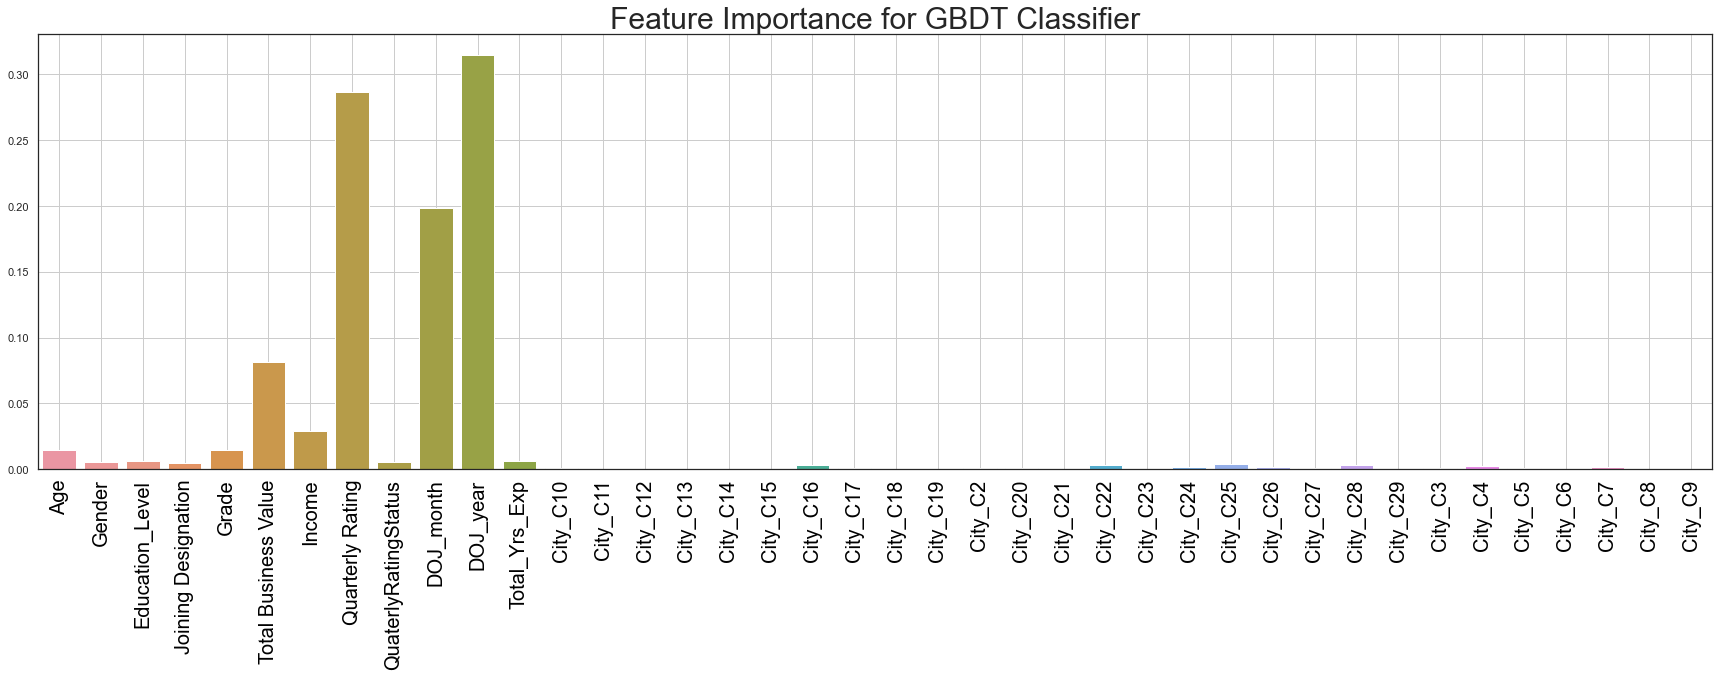

In [127]:
#Feature Importance
plt.figure(figsize=(30,8))
plt.title("Feature Importance for GBDT Classifier",fontsize = 30) # Create plot title
sns.barplot(x = X_train.columns,y = gbdt_sm.feature_importances_)
plt.xticks(rotation=90,color="black",fontsize = 20)
plt.grid()
plt.show()

## Boosting Method - XGBoost

In [128]:
## Training the model using the best hyperparameters
xgb_sm = XGBClassifier(n_estimators=50,subsample=1.0, max_depth=5, learning_rate=0.1, colsample_bytree=0.6)
xgb_sm.fit(X_sm, y_sm)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Classification Report
-------------------------
              precision    recall  f1-score   support

       Churn       0.96      0.91      0.93       171
      Retain       0.79      0.91      0.85        68

    accuracy                           0.91       239
   macro avg       0.88      0.91      0.89       239
weighted avg       0.91      0.91      0.91       239

________________________________________________________________________________
Performance metrics
-------------------------
Precision: 0.795
Recall: 0.912
F1 score : 0.849


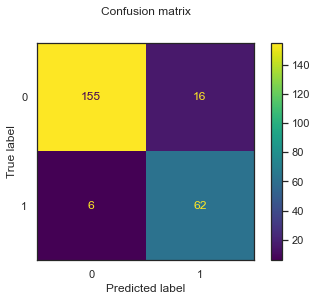

In [129]:
print("Classification Report")
print("-"*25)
Y_pred = xgb_sm.predict(X_test)
print(f"{classification_report(y_test,Y_pred, target_names=['Churn','Retain'])}")
print("_"*80)
print("Performance metrics")
print("-"*25)
Precision = precision_score(y_test,Y_pred).round(3)
Recall = recall_score(y_test, Y_pred).round(3)
F1score = f1_score(y_test, Y_pred).round(3)
print('Precision:', Precision)
print('Recall:', Recall)
print("F1 score :",F1score)


confusion = confusion_matrix(y_test,Y_pred)
TP = confusion[1,1] # true positive
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion).plot()
plt.title('Confusion matrix', y=1.1)
plt.show()

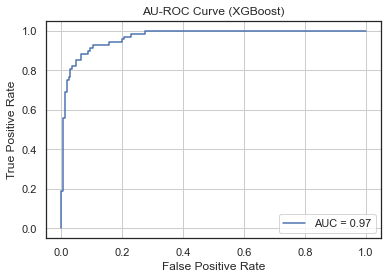

In [130]:
y_pred_proba = xgb_sm.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(4)
#create ROC curve
plt.plot(fpr,tpr,label="AUC = "+ str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.grid()
plt.title("AU-ROC Curve (XGBoost)")
plt.show()

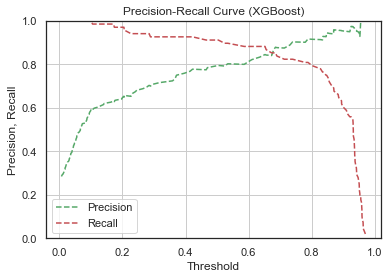

In [132]:
from sklearn.metrics import precision_recall_curve
probs_y=xgb_sm.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1])
plt.title("Precision-Recall Curve (XGBoost)")
plt.plot(thresholds, precision[: -1], "g--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.grid()
plt.show()

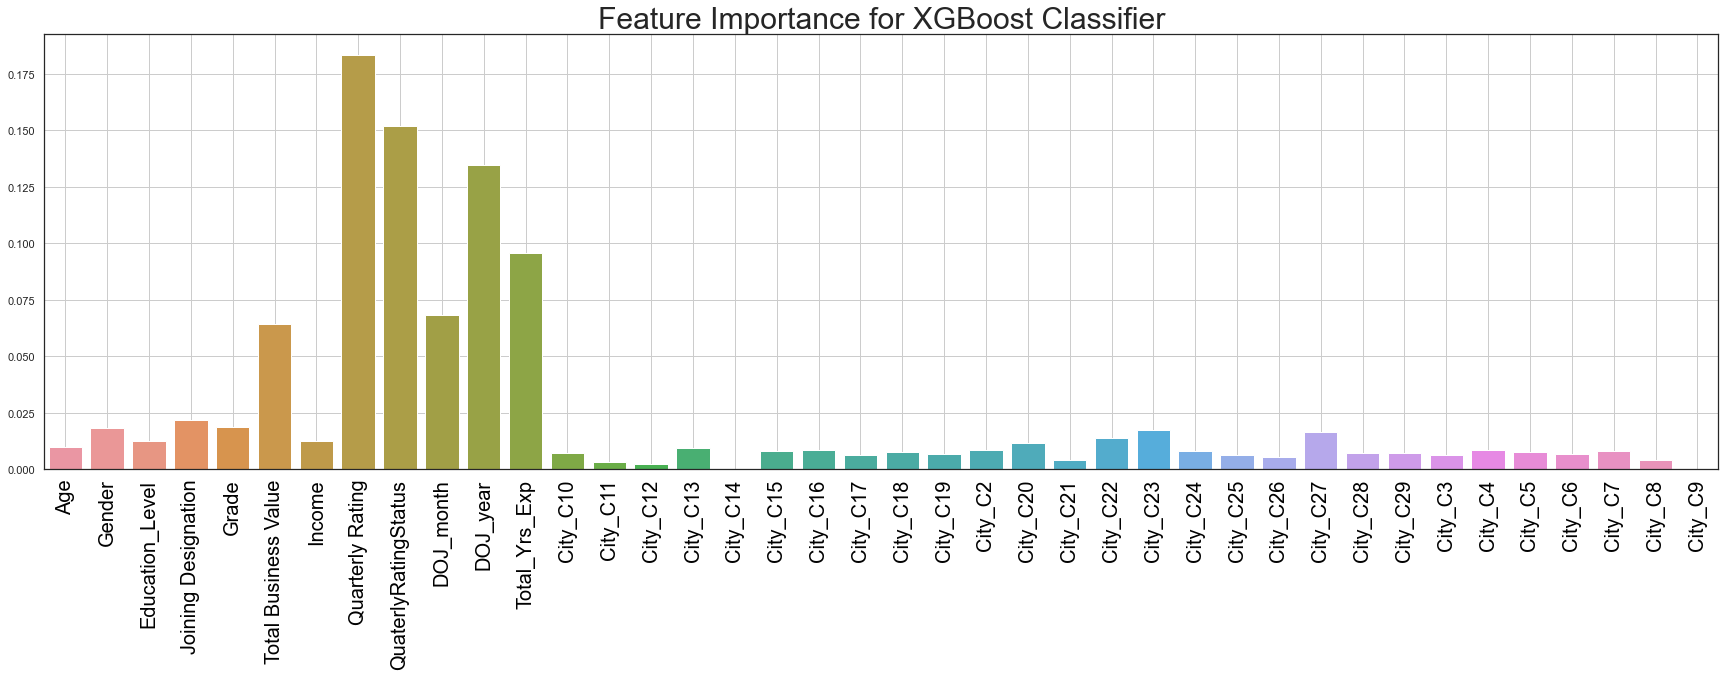

In [134]:
#Feature Importance
plt.figure(figsize=(30,8))
plt.title("Feature Importance for XGBoost Classifier",fontsize = 30) # Create plot title
sns.barplot(x = X_train.columns,y = xgb_sm.feature_importances_)
plt.xticks(rotation=90,color="black",fontsize = 20)
plt.grid()
plt.show()

## **Result Evaluation for Imbalance Treatment using SMOTE**

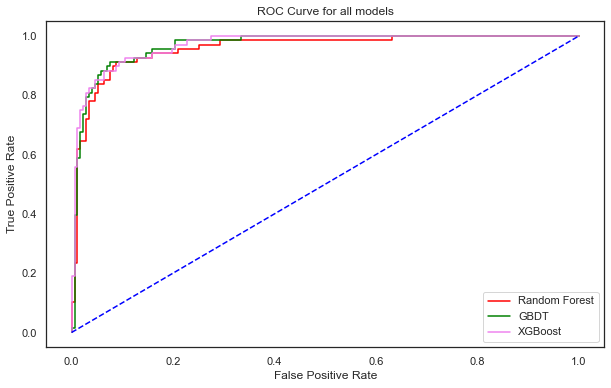

ROC - AUC score for different models using SMOTE: 
* Random Forest: 95.7
* GBDT: 96.73
* XGBoost: 97.0
--------------------------------------------------------------------------------
F1 score for different models using SMOTE: 
*  Random Forest: 85.517
*  GBDT : 84.932
*  XGBoost : 84.932


In [138]:
# Plot ROC Curve of three models
from sklearn.metrics import roc_curve


rf_y_test_pred_proba = rfmodel_sm.predict_proba(X_test)[:,1]
gb_y_test_pred_proba = gbdt_sm.predict_proba(X_test)[::,1]
xgb_y_test_pred_proba = xgb_sm.predict_proba(X_test)[:,1]

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_y_test_pred_proba)
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_test, gb_y_test_pred_proba)
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_y_test_pred_proba)


# plot TPR against FPR
plt.figure(figsize=(10,6))

rf_plot = plt.plot(rf_fpr, rf_tpr, color='red')
gbt_plot = plt.plot(gb_fpr, gb_tpr, color='green')
xgbt_plot = plt.plot(xgb_fpr, xgb_tpr, color='violet')
plt.legend([ 'Random Forest','GBDT',"XGBoost"],loc='lower right')

# plot 45 degree line
xx = np.linspace(0, 1, 20)
plt.plot(xx, xx, color='blue',linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for all models")
plt.savefig('ROC')
plt.show()

print("ROC - AUC score for different models using SMOTE: ")
print("* Random Forest:",roc_auc_score(y_test,rf_y_test_pred_proba).round(3)*100)
print("* GBDT:",roc_auc_score(y_test,gb_y_test_pred_proba).round(4)*100)
print("* XGBoost:",roc_auc_score(y_test,xgb_y_test_pred_proba).round(4)*100)

print("-"*80)

print("F1 score for different models using SMOTE: ")
print("*  Random Forest:" ,f1_score(y_test, rfmodel_sm.predict(X_test)).round(5)*100)
print("*  GBDT :" ,f1_score(y_test, gbdt_sm.predict(X_test)).round(5)*100)
print("*  XGBoost :" ,f1_score(y_test, xgb_sm.predict(X_test)).round(5)*100)

**AUC - ROC curve** is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. The blue line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).


> * **ROC - AUC score : XGBoost >= Random Forest > GBDT**
> * **F1 score : XGBoost >= Random Forest > GBDT**

## Conclusions

* Drivers who has Grade 1 and 2 having highest percentage difference in leaving the company
* In terms of city, C20,C26, C15 has highest percentage of drivers leaving the job while C29 is lower.
* Drivers whose age between 30 to 36 having higher percentage leaving the company.
* Joining Designation of drivers 1 and 2 showing more interest in leaving the company.
* Only Quarterly rating 1 drivers showing more interest in leaving the company.
* Increasing Income Level is proportional to driver who are not leaving the company

> **Out of all models, XGBoost algorithm predicts the driver churned has few feature importance and almost slightly greater accuracy than Random Forest and GBDT.**

## **Business Insights and Recommendations**

* As per the  result evaluation on four tree-based models, we can rank them as follows based on their prediction performance metrics:

    #### **Model (XGBoost)  >= Model (Random Forest) > Model (GBDT)**
    

* Using the feature importance insights generated from the models, some important predictors of driver attrition are :-

1) **QuarterlyRating and QuarterlyRating_Increment**:

>* Drivers with an increase in their quarterly rating were more likely to stay with the company.

The quarterly rating by driver is not something that can be changed by the company. We suspect that passengers with poor ratings are not selected by drivers, and thus have a harder time getting rides. This leads to attrition, but perhaps it isn't bad for the company to lose the worst riders.

Company should identify the driver profile with low/high quarterly rating and extend loyalty programs that incentivizes performance improvements. Quarterly performance reviews and additional training could be imparted to the drivers whose rating has not increased over the last quarter so that issues can be identified with concerned drivers and attrition can be prevented.



2) **Total Business Value:**
> * An important feature in predicting if a driver is going to leave the company or not.

The total business value is the total business that a driver generates, the company should set small financial milestones for the drivers to work through. The company should roll out a reward and recognition program for the drivers who meet their milestones.

3) **Income/Grade:**
>* Income plays an important role in predicting the driver attrition.

Company should ensure that the drivers have enough opportunities and motivation to increase their monthly average income above a certain threshold. Another option to ease the financial burden on the drivers and increase their morale is to provide vehicle maintenance offers, insurance policies, health checkups, subsidized education programs etc. to the drivers in order to cement driver loyalty.

4) **Age :**

Employees in relatively young age bracket 25-35 are more likely to leave. Hence, efforts should be made to clearly articulate the long-term vision of the company and young employees fit in that vision, as well as provide incentives in the form of clear paths to promotion for instance.

5) Need to revise grading mechanism, since lower grade drivers are leaving the company frequently.

6) Conducting a job satisfaction survey for drivers age between 30 and 36 since they are most percentile leaving the company. with information those drivers gives much information.

7) Out of all models, Quarterly rating plays a major role in predicting the attrition rate, Therefore, by evaluating that if increasing income level or giving incentive to drivers who has higher quarterly rating will reduce the attrition rate or not.

8) By giving small coupons to peoples who are giving rating to drivers, will be directly impact on getting rating for each ride. With rating, we can take decisions since quarterly rating plays major impact on retaining drivers in the company


### **Submitted by : Mrudula A P**